# ADC PROJECT 
## Social Signed Network - ***rfa-Wiki***
### Voting for Admins

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import os

import spacy
from spacy import displacy

import matplotlib.pyplot as plt

sns.set(style="whitegrid")

In [3]:
df = pd.read_csv("./Data/wiki_RfA_2010_2013.csv")
df.dtypes

SRC            object
TGT            object
VOT             int64
RES             int64
YEA             int64
DAT            object
TXT            object
cleaned_TXT    object
dtype: object

In [4]:
df

,SRC,TGT,VOT,RES,YEA,DAT,TXT,cleaned_TXT
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''''' as co-nom.,co
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''''' as nominator.--,nominator
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''''' per noms.,noms
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''''' per noms. BDD is a strong contributor w...,noms bdd strong contributor thousand edits yea...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''''', with great pleasure. I work with BDD a...",great pleasure work bdd coordinator seen good ...
...,...,...,...,...,...,...,...,...
32305,Atama,ZooPro,-1,-1,2010,2010-02-22 18:17:00,"'''''' - Per Polargeo, and per [http://en.wiki...",polargeo deal killer someone want work deletio...
32306,Bradjamesbrown,ZooPro,-1,-1,2010,2010-02-22 18:18:00,'''''' per SilkTork's diff above. Asserting [[...,silktork asserting article portal good behavio...
32307,Ottawa4ever,ZooPro,0,-1,2010,2010-02-22 18:11:00,"'''''' Not to pile on, neutral. I cannot suppo...",pile neutral support smithers pointed feeding ...
32308,Tryptofish,ZooPro,0,-1,2010,2010-02-22 17:58:00,'''''' I've interacted with this editor at var...,interacted editor various animal related page ...


In [5]:
# Assuming df is the DataFrame that you've already filtered and processed
# Create a signed graph
def create_signed_graph(df):
    """
    Create a MultiDiGraph from a DataFrame with edges labeled by interaction type.

    Parameters:
        df (pd.DataFrame): DataFrame containing columns for edges and attributes.

    Returns:
        G (nx.MultiDiGraph): The created graph.
    """
    G = nx.MultiDiGraph()  # Use MultiDiGraph to allow multiple edges between nodes

    # Iterate through the rows of the DataFrame to add edges and nodes
    for _, row in df.iterrows():
        src = row['SRC']  # Source node
        tgt = row['TGT']  # Target node
        vot = row['VOT']  # Label: -1, 1, or possibly NaN
        txt = row['TXT']  # Additional textual information
        res = row['RES']  # Admin status: 1 for admin, 0 for nonAdmin
        dat = row['DAT']  # Date or timestamp attribute

        # Skip edges without a valid label
        if vot not in [-1, 1]:
            continue

        # Add nodes if they don't already exist
        if src not in G:
            G.add_node(src)
        if tgt not in G:
            G.add_node(tgt)

        # Determine admin status for the edge
        admin_status = "admin" if res == 1 else "nonAdmin"

        # Add edge with attributes, storing `VOT` as a label, not a weight
        edge_attrs = {
            'label': vot,   # Interaction type (-1, 1)
            'txt': txt,     # Additional text data
            'admin': admin_status,  # Whether the interaction involves an admin
            'DAT': dat      # Timestamp or date
        }
        G.add_edge(src, tgt, **edge_attrs)  # Add the edge with all attributes
    
    return G

# Create the signed graph
G = create_signed_graph(df)

G


### Basic Characteristics

#### Number of Nodes

In [32]:
G.number_of_nodes()

2934

#### Number of Edges

In [33]:
total =G.number_of_edges()
total

30252

In [34]:
label_1_count = sum(1 for _, _, d in G.edges(data=True) if d.get("label") == 1)
label_minus_1_count = sum(1 for _, _, d in G.edges(data=True) if d.get("label") == -1)

print(f"Number of edges with label=1: {label_1_count}")
print(f"Number of edges with label=-1: {label_minus_1_count}")


Number of edges with label=1: 23035
Number of edges with label=-1: 7217


In [35]:
# Calculate percentages
label_1_percentage = (label_1_count / total) * 100
label_minus_1_percentage = (label_minus_1_count / total) * 100

print(f"Percentage of edges with label=1: {label_1_percentage:.2f}%")
print(f"Percentage of edges with label=-1: {label_minus_1_percentage:.2f}%")


Percentage of edges with label=1: 76.14%
Percentage of edges with label=-1: 23.86%


In [36]:
first_edge = next(iter(G.edges(data=True)))
type(first_edge[2]["label"])

int

In [37]:
import networkx as nx

# Convert MultiDiGraph to an undirected graph
def convert_to_undirected(G):
    """
    Convert a MultiDiGraph to an undirected graph, resolving edge labels.

    Args:
        G (nx.MultiDiGraph): Input multi-directed graph with "label" attributes.

    Returns:
        nx.Graph: Undirected graph with resolved edge labels.
    """
    # Create an undirected graph
    U = nx.Graph()
    
    for u, v, data in G.edges(data=True):
        # Check if the edge already exists
        if U.has_edge(u, v):
            # Prioritise negative label if it exists
            if data.get("label") == -1:
                U[u][v]["label"] = -1
        else:
            # Add the edge with its label
            U.add_edge(u, v, label=data.get("label"))
    
    return U

# Convert the MultiDiGraph G to an undirected graph
G_undirected = convert_to_undirected(G)


In [38]:
import itertools

# Initialise counts for each type of triad
triad_counts = {"+++": 0, "+−−": 0, "++−": 0, "−−−": 0}

# Iterate over all nodes in the graph
for node in G_undirected.nodes():
    # Get neighbours of the current node
    neighbours = list(G_undirected.neighbors(node))
    # Check all pairs of neighbours
    for u, v in itertools.combinations(neighbours, 2):
        # Ensure a triangle exists
        if G_undirected.has_edge(u, v):
            # Fetch labels for each edge in the triangle
            labels = [
                G_undirected[node][u]["label"],  # node -- u
                G_undirected[u][v]["label"],    # u -- v
                G_undirected[v][node]["label"], # v -- node
            ]
            # Categorise the triad based on its edge labels
            if labels == [1, 1, 1]:
                triad_counts["+++"] += 1
            elif labels == [1, -1, -1]:
                triad_counts["+−−"] += 1
            elif labels == [1, 1, -1] or labels == [1, -1, 1] or labels == [-1, 1, 1]:
                triad_counts["++−"] += 1
            elif labels == [-1, -1, -1]:
                triad_counts["−−−"] += 1

# Print results
for triad, count in triad_counts.items():
    print(f"Number of {triad} triads: {count}")


Number of +++ triads: 295961
Number of +−− triads: 20820
Number of ++− triads: 131003
Number of −−− triads: 10563


### Avreage Degree

### Max Degree - TOP 20

In [13]:

# Assuming G is your directed graph

# Get the in-degree and out-degree of all nodes
in_degree_dict = dict(G.in_degree())
out_degree_dict = dict(G.out_degree())

# Combine in-degree and out-degree for each node
degree_info = {
    node: {"in_degree": in_degree_dict.get(node, 0), "out_degree": out_degree_dict.get(node, 0)}
    for node in G.nodes()
}

# Sort nodes by in-degree and out-degree
top_20_in_degree = sorted(degree_info.items(), key=lambda x: x[1]["in_degree"], reverse=True)[:20]
top_20_out_degree = sorted(degree_info.items(), key=lambda x: x[1]["out_degree"], reverse=True)[:20]

# Print the top 20 nodes with in-degree and out-degree
print("Top 20 nodes by in-degree:")
for node, degrees in top_20_in_degree:
    print(f"User: {node}, In-degree: {degrees['in_degree']}")

print("\nTop 20 nodes by out-degree:")
for node, degrees in top_20_out_degree:
    print(f"User: {node}, Out-degree: {degrees['out_degree']}")


Top 20 nodes by in-degree:
User: HJ Mitchell, In-degree: 314
User: Connormah, In-degree: 296
User: Ironholds, In-degree: 275
User: Lord Roem, In-degree: 263
User: The Thing That Should Not Be, In-degree: 240
User: Everyking, In-degree: 233
User: SarekOfVulcan, In-degree: 227
User: SarahStierch, In-degree: 216
User: DeltaQuad, In-degree: 214
User: GiantSnowman, In-degree: 212
User: Drmies, In-degree: 205
User: Σ, In-degree: 200
User: Richwales, In-degree: 189
User: Dabomb87, In-degree: 188
User: 28bytes, In-degree: 183
User: Elen of the Roads, In-degree: 181
User: Soap, In-degree: 180
User: My76Strat, In-degree: 179
User: MZMcBride, In-degree: 179
User: Ling.Nut, In-degree: 176

Top 20 nodes by out-degree:
User: Boing! said Zebedee, Out-degree: 246
User: Fastily, Out-degree: 242
User: Ktr101, Out-degree: 231
User: Fetchcomms, Out-degree: 221
User: Mkativerata, Out-degree: 185
User: Axl, Out-degree: 180
User: Minimac, Out-degree: 178
User: RP459, Out-degree: 174
User: Kudpung, Out-degree

### Clustering

Average Clustering Coefficient: 0.12484940859574861


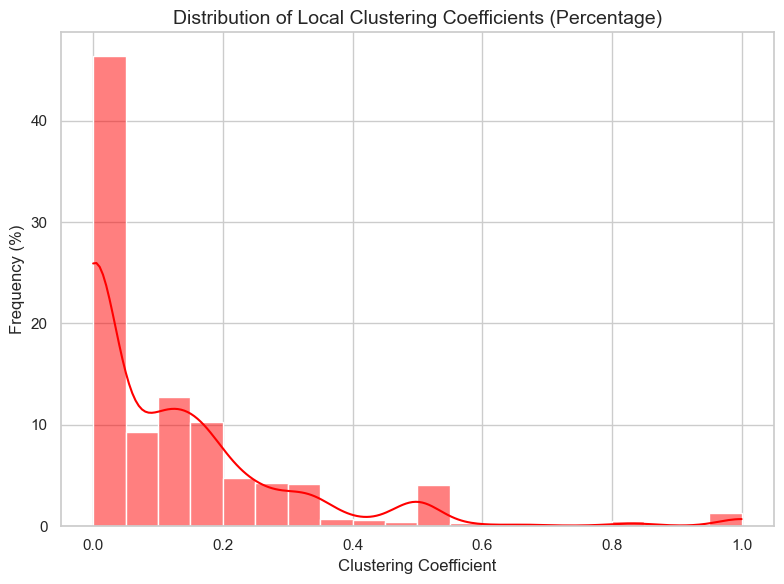

In [27]:
# Convert MultiDiGraph to DiGraph (collapse multiple edges)
G_simple = nx.DiGraph()
for u, v, data in G.edges(data=True):
    if not G_simple.has_edge(u, v):
        G_simple.add_edge(u, v, **data)

# Compute clustering coefficients
local_clustering = nx.clustering(G_simple)  # Local clustering coefficient
average_clustering = nx.average_clustering(G_simple)  # Average clustering coefficient

# Print the results
print(f"Average Clustering Coefficient: {average_clustering}")

# Create the 'plots' directory if it doesn't exist
if not os.path.exists('plots'):
    os.makedirs('plots')

# Set up the plot figure
plt.figure(figsize=(8, 6))

# Plot the distribution of local clustering coefficients (percentages)
plt.subplot(1, 1, 1)  # Only one plot, so 1 row, 1 column, 1st position
sns.histplot(list(local_clustering.values()), kde=True, color='red', bins=20, stat='percent')
plt.title("Distribution of Local Clustering Coefficients (Percentage)", fontsize=14)
plt.xlabel("Clustering Coefficient", fontsize=12)
plt.ylabel("Frequency (%)", fontsize=12)

# Adjust the layout
plt.tight_layout()

# Save the plot to the 'plots' folder
plt.savefig('plots/clustering_coefficient_distribution_percentage.png')

# Show the plot
plt.show()

In [57]:
simple_G = nx.DiGraph(G)

# Calculate the global clustering coefficient
global_clustering_coefficient = nx.transitivity(simple_G)

# Print the result
print("Global Clustering Coefficient:", global_clustering_coefficient)


# Calculate the degree assortativity coefficient
assortativity = nx.degree_assortativity_coefficient(G)

print(assortativity)
reciprocity = nx.reciprocity(G)

reciprocity


Global Clustering Coefficient: 0.12841768180324115
-0.1327251988741774


0.05052716677333513

In [62]:
# Calculate assortativity based on in-degree
positive_assortativity_in = nx.degree_assortativity_coefficient(G, x='in', y='out')

# Calculate assortativity based on out-degree
positive_assortativity_out = nx.degree_assortativity_coefficient(G, x='out', y='in')

positive_assortativity_in, positive_assortativity_out


(0.009457824523006494, -0.1327251988741774)

In [63]:
label_assortativity = nx.attribute_assortativity_coefficient(G, 'label')

label_assortativity

/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in scalar divide
  r = (t - s) / (1 - s)


nan

Average In-Degree: 10.12
Average Out-Degree: 10.12
Average Degree (In + Out): 20.24

Clustering Coefficients and Degrees:
                 Node  Clustering_Coefficient  In_Degree  Out_Degree
0           Steel1943                0.000000          0           2
1                 BDD                0.048588        133           4
2          Cuchullain                0.000000          0           2
3           INeverCry                0.108701        109          23
4           Cncmaster                0.117647          0          17
...               ...                     ...        ...         ...
2929               DF                0.000000          0           1
2930  Wilhelmina Will                0.192308         26           0
2931         YOSF0113                0.000000          1           0
2932     Youndbuckerz                0.126374         14           0
2933           Yuvmil                0.300000          5           0

[2934 rows x 4 columns] 



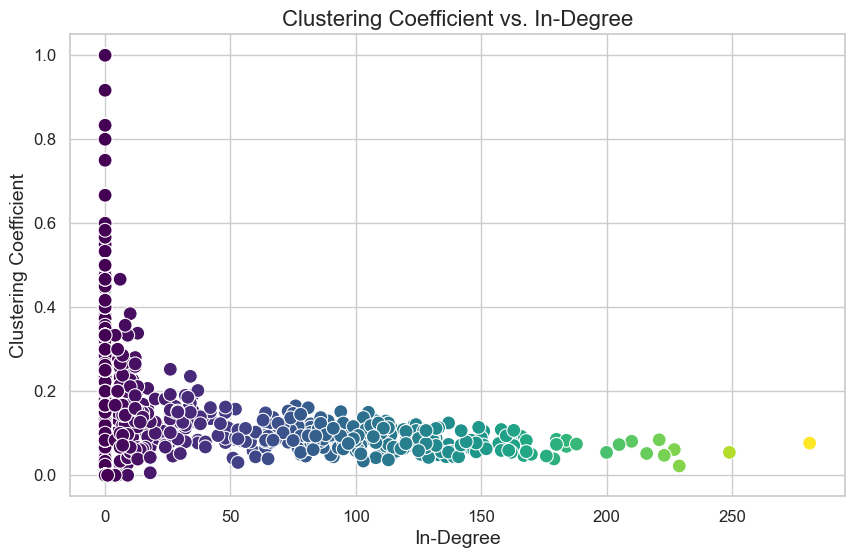

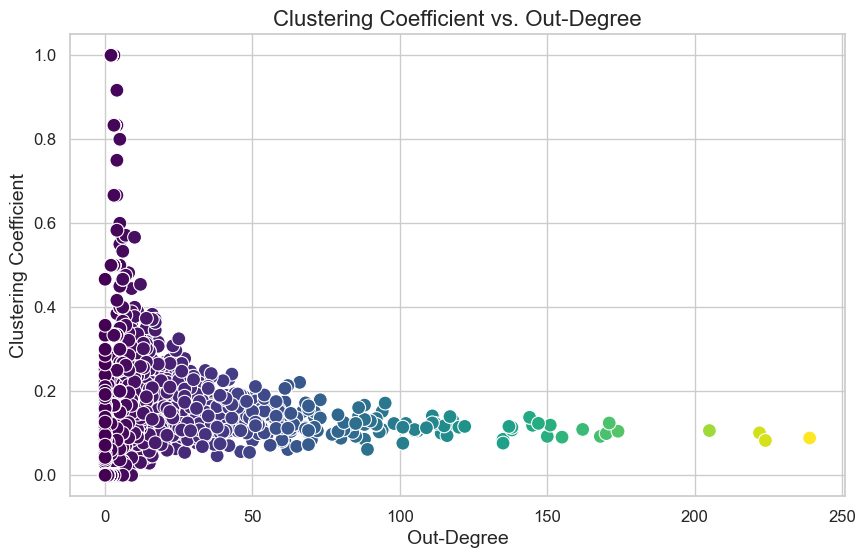

Overall Average Clustering Coefficient: 0.1248
Overall Transitivity (Global Clustering Coefficient): 0.1284

Average Clustering Coefficient (VOT = -1): 0.0118
Transitivity (VOT = -1): 0.0243

Average Clustering Coefficient (VOT = 1): 0.1081
Transitivity (VOT = 1): 0.1389



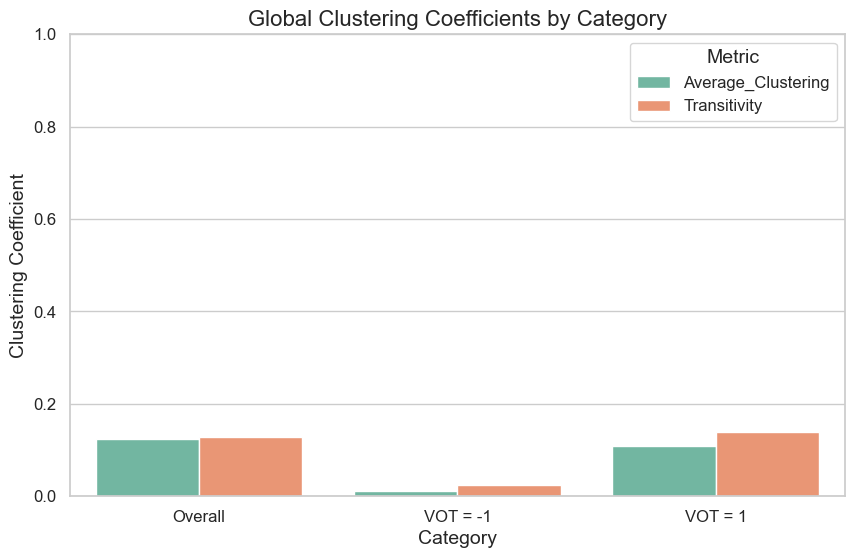

In-Degree Counts: Counter({6: 18, 9: 13, 8: 12, 3: 11, 7: 10, 10: 10, 4: 10, 26: 9, 13: 9, 12: 9, 15: 8, 5: 7, 78: 5, 64: 5, 113: 5, 93: 5, 11: 5, 86: 5, 18: 5, 109: 4, 30: 4, 29: 4, 34: 4, 90: 4, 17: 4, 103: 4, 112: 4, 83: 4, 95: 4, 87: 4, 81: 4, 48: 4, 2: 4, 32: 4, 108: 3, 99: 3, 132: 3, 74: 3, 137: 3, 67: 3, 42: 3, 97: 3, 124: 3, 114: 3, 122: 3, 65: 3, 52: 3, 38: 3, 94: 3, 73: 3, 121: 3, 21: 3, 75: 3, 53: 3, 82: 3, 37: 3, 71: 3, 128: 3, 77: 3, 120: 3, 20: 3, 24: 3, 133: 2, 162: 2, 46: 2, 161: 2, 180: 2, 146: 2, 131: 2, 91: 2, 35: 2, 105: 2, 127: 2, 110: 2, 184: 2, 129: 2, 98: 2, 85: 2, 150: 2, 151: 2, 49: 2, 63: 2, 106: 2, 96: 2, 168: 2, 89: 2, 158: 2, 28: 2, 148: 2, 119: 2, 102: 2, 115: 2, 100: 2, 163: 2, 84: 2, 80: 2, 111: 2, 60: 2, 125: 2, 101: 2, 56: 2, 16: 2, 27: 2, 23: 2, 142: 2, 33: 2, 1: 2, 40: 2, 14: 2, 166: 1, 59: 1, 123: 1, 227: 1, 39: 1, 136: 1, 76: 1, 216: 1, 134: 1, 126: 1, 138: 1, 210: 1, 147: 1, 157: 1, 149: 1, 51: 1, 167: 1, 139: 1, 179: 1, 58: 1, 249: 1, 170: 1, 22

In [64]:
# Import necessary libraries
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

# Set Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Function to create a subgraph based on edge attribute 'VOT'
def create_subgraph_by_vot(G, vot_value):
    """
    Creates a subgraph containing only edges with the specified 'VOT' value.

    Parameters:
        G (networkx.DiGraph): The input directed graph.
        vot_value (int): The 'VOT' value to filter edges (-1 or 1).

    Returns:
        networkx.DiGraph: The resulting subgraph.
    """
    # Initialize an empty DiGraph
    SG = nx.DiGraph()
    
    # Add nodes
    SG.add_nodes_from(G.nodes())
    
    # Add edges with the specified 'VOT' value
    for u, v, data in G.edges(data=True):
        if data.get('label') == vot_value:
            SG.add_edge(u, v)
    
    return SG

# Function to extract and filter degrees
def get_filtered_degrees(G, degree_type='in'):
    """
    Extracts and filters degrees from the graph based on degree type.

    Parameters:
        G (networkx.DiGraph): The input directed graph (should be simple, not MultiDiGraph).
        degree_type (str): 'in' for in-degree, 'out' for out-degree.

    Returns:
        list: Filtered degrees excluding zero degrees.
    """
    if degree_type == 'in':
        degrees = [deg for _, deg in G.in_degree() if deg > 0]
    elif degree_type == 'out':
        degrees = [deg for _, deg in G.out_degree() if deg > 0]
    else:
        raise ValueError("degree_type must be 'in' or 'out'.")
    return degrees

# Function to plot clustering coefficient distributions
def plot_clustering_distribution(df, degree_type='in'):
    """
    Plots the distribution of clustering coefficients based on degree type.

    Parameters:
        df (pd.DataFrame): DataFrame containing clustering coefficients and degrees.
        degree_type (str): 'in' for in-degree, 'out' for out-degree.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df, 
        x=degree_type.capitalize() + '_Degree', 
        y='Clustering_Coefficient', 
        hue=degree_type.capitalize() + '_Degree', 
        palette='viridis', 
        legend=False,
        s=100
    )
    plt.title(f'Clustering Coefficient vs. {degree_type.capitalize()}-Degree', fontsize=16)
    plt.xlabel(f'{degree_type.capitalize()}-Degree', fontsize=14)
    plt.ylabel('Clustering Coefficient', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# Function to plot global clustering coefficients
def plot_global_clustering(clustering_data):
    """
    Plots the global clustering coefficients for different categories.

    Parameters:
        clustering_data (pd.DataFrame): DataFrame containing clustering coefficients for each category.
    """
    # Melt the DataFrame for easier plotting
    df_melted = clustering_data.melt(id_vars='Category', value_vars=['Average_Clustering', 'Transitivity'], 
                                     var_name='Metric', value_name='Value')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_melted, x='Category', y='Value', hue='Metric', palette='Set2')
    plt.title('Global Clustering Coefficients by Category', fontsize=16)
    plt.xlabel('Category', fontsize=14)
    plt.ylabel('Clustering Coefficient', fontsize=14)
    plt.ylim(0, 1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Metric', fontsize=12, title_fontsize=14)
    plt.show()

# ================================
# Step 1: Create or Load Your Graph
# ================================

# ================================
# Step 2: Convert MultiDiGraph to DiGraph for Clustering Analysis
# ================================

# Convert MultiDiGraph to DiGraph (aggregating multiple edges)
G = nx.DiGraph(G_multi)

# Optionally, remove self-loops if not needed
G.remove_edges_from(nx.selfloop_edges(G))

# ================================
# Step 3: Calculate Degrees and Clustering Coefficients
# ================================

# Extract degrees (excluding zero degrees)
in_degrees = get_filtered_degrees(G, 'in')
out_degrees = get_filtered_degrees(G, 'out')

# Calculate totals
total_in_degree = sum(in_degrees)
total_out_degree = sum(out_degrees)
num_nodes = G.number_of_nodes()

# Calculate averages
average_in_degree = total_in_degree / num_nodes if num_nodes > 0 else 0
average_out_degree = total_out_degree / num_nodes if num_nodes > 0 else 0
average_degree = average_in_degree + average_out_degree

print(f"Average In-Degree: {average_in_degree:.2f}")
print(f"Average Out-Degree: {average_out_degree:.2f}")
print(f"Average Degree (In + Out): {average_degree:.2f}\n")

# Calculate local clustering coefficients
clustering_coeffs = nx.clustering(G)

# Convert to a pandas DataFrame for easier analysis
df_clustering = pd.DataFrame({
    'Node': list(clustering_coeffs.keys()),
    'Clustering_Coefficient': list(clustering_coeffs.values())
})

# Calculate in-degree and out-degree for each node
df_clustering['In_Degree'] = [deg for _, deg in G.in_degree()]
df_clustering['Out_Degree'] = [deg for _, deg in G.out_degree()]

# Display the DataFrame
print("Clustering Coefficients and Degrees:")
print(df_clustering, "\n")

# ================================
# Step 4: Analyze Clustering Coefficient Distributions
# ================================

# Plot Clustering Coefficient vs. In-Degree
plot_clustering_distribution(df_clustering, degree_type='in')

# Plot Clustering Coefficient vs. Out-Degree
plot_clustering_distribution(df_clustering, degree_type='out')

# ================================
# Step 5: Calculate and Visualize Global Clustering Coefficients
# ================================

# Overall Global Clustering Coefficient (Average Clustering)
avg_clustering = nx.average_clustering(G)
print(f"Overall Average Clustering Coefficient: {avg_clustering:.4f}")

# Transitivity (Global Clustering Coefficient)
transitivity = nx.transitivity(G)
print(f"Overall Transitivity (Global Clustering Coefficient): {transitivity:.4f}\n")

# Create subgraphs based on 'VOT' attribute
G_vot_minus1 = create_subgraph_by_vot(G_multi, -1)
G_vot_plus1 = create_subgraph_by_vot(G_multi, 1)

# Convert subgraphs to DiGraph (aggregate multiple edges)
G_vot_minus1 = nx.DiGraph(G_vot_minus1)
G_vot_plus1 = nx.DiGraph(G_vot_plus1)

# Remove self-loops if necessary
G_vot_minus1.remove_edges_from(nx.selfloop_edges(G_vot_minus1))
G_vot_plus1.remove_edges_from(nx.selfloop_edges(G_vot_plus1))

# Calculate global clustering coefficients for each subgraph
avg_clustering_minus1 = nx.average_clustering(G_vot_minus1)
transitivity_minus1 = nx.transitivity(G_vot_minus1)

avg_clustering_plus1 = nx.average_clustering(G_vot_plus1)
transitivity_plus1 = nx.transitivity(G_vot_plus1)

print(f"Average Clustering Coefficient (VOT = -1): {avg_clustering_minus1:.4f}")
print(f"Transitivity (VOT = -1): {transitivity_minus1:.4f}\n")

print(f"Average Clustering Coefficient (VOT = 1): {avg_clustering_plus1:.4f}")
print(f"Transitivity (VOT = 1): {transitivity_plus1:.4f}\n")

# Prepare data for visualization
clustering_data = pd.DataFrame({
    'Category': ['Overall', 'VOT = -1', 'VOT = 1'],
    'Average_Clustering': [avg_clustering, avg_clustering_minus1, avg_clustering_plus1],
    'Transitivity': [transitivity, transitivity_minus1, transitivity_plus1]
})

# Plot Global Clustering Coefficients
plot_global_clustering(clustering_data)

# ================================
# Step 6: Additional Verification
# ================================

# Cross-Check Degree Counts
# Get degree counts
in_degree_counts = Counter(in_degrees)
out_degree_counts = Counter(out_degrees)

print("In-Degree Counts:", in_degree_counts)
print("Out-Degree Counts:", out_degree_counts, "\n")

# Sum of counts should match total degrees
sum_in_degree_counts = sum(in_degree_counts.values())
sum_out_degree_counts = sum(out_degree_counts.values())

print(f"Sum of In-Degree Counts: {sum_in_degree_counts}")
print(f"Sum of Out-Degree Counts: {sum_out_degree_counts}")
print(f"Calculated Total In-Degree: {total_in_degree}")
print(f"Calculated Total Out-Degree: {total_out_degree}\n")

# Assertions for verification
try:
    assert sum_in_degree_counts == total_in_degree, "Mismatch in In-Degree counts!"
    assert sum_out_degree_counts == total_out_degree, "Mismatch in Out-Degree counts!"
    print("Degree counts match successfully.")
except AssertionError as e:
    print(str(e))


### Small World Properties

Calculating **Shortest Path**


In [18]:
import networkx as nx

# Assuming G is your directed graph (MultiDiGraph or DiGraph)
# First, find the largest strongly connected component (SCC)
strongly_connected_components = list(nx.strongly_connected_components(G))
largest_scc = max(strongly_connected_components, key=len)

# Create a subgraph from the largest SCC
G_scc = G.subgraph(largest_scc)


avg_shortest_path_length = nx.average_shortest_path_length(G_scc)
print(f"Average Shortest Path Length: {avg_shortest_path_length}")



Average Shortest Path Length: 2.4228483202154583


A **Strongly Connected Component (SCC)**: of a directed graph is a maximal subgraph in which every node is reachable from every other node following the direction of the edges.
Characteristics of SCCs:

- In a strongly connected component, for any two nodes uu and vv, there exists:
    - A directed path from uu to vv.
    - A directed path from vv to uu.
- SCCs partition the nodes of the graph; every node belongs to exactly one SCC.


Useful for understanding fully reciprocal relationships in directed networks, such as social or communication networks.

In [16]:
# Find strongly connected components
strongly_connected_components = list(nx.strongly_connected_components(G))

# Count the number of components
num_components = len(strongly_connected_components)

print(f"Number of strongly connected components: {num_components}")

Number of strongly connected components: 2641


A **Weakly Connected Component (WCCs)** of a directed graph is a maximal subgraph where all nodes are connected if you ignore the direction of the edges.
Characteristics of WCCs:

- In a weakly connected component, there exists an undirected path between any two nodes (disregarding edge direction).
- WCCs are larger than or equal to SCCs because ignoring direction may merge multiple SCCs into one WCC.

Helpful when you care about overall connectivity, regardless of direction, such as transportation or infrastructure networks.

In [17]:
# Find weakly connected components
weakly_connected_components = list(nx.weakly_connected_components(G))

# Count the number of weakly connected components
num_weak_components = len(weakly_connected_components)

print(f"Number of weakly connected components: {num_weak_components}")


Number of weakly connected components: 1


| **Property**                 | **SCC (Strongly Connected Component)** | **WCC (Weakly Connected Component)** |
|------------------------------|-----------------------------------------|---------------------------------------|
| **Definition**               | Nodes are mutually reachable via directed paths. | Nodes are connected when edge directions are ignored. |
| **Path Requirement**         | Direction matters.                     | Direction is ignored.                |
| **Applicability**            | Stronger condition, specific to directed graphs. | A weaker condition, closer to undirected connectivity. |
| **Size Relationship**        | SCCs are smaller or equal to WCCs.     | WCCs are larger or equal to SCCs.    |


**Cannot Calculate Diameter of the Whole Graph** due to not being strongly connected (Diameter fails)


In [18]:
# Assuming G is your directed graph (DiGraph or MultiDiGraph)
# Find the largest strongly connected component
strongly_connected_components = list(nx.strongly_connected_components(G))
largest_scc = max(strongly_connected_components, key=len)

# Create a subgraph from the largest SCC
G_scc = G.subgraph(largest_scc)

# Calculate the diameter if the subgraph is strongly connected
if nx.is_strongly_connected(G_scc):
    graph_diameter = nx.diameter(G_scc)
    print(f"Diameter of the largest strongly connected component: {graph_diameter}")
else:
    print("The graph is not strongly connected, and diameter cannot be calculated directly.")

Diameter of the largest strongly connected component: 6


### Voting Type Distribution

In [19]:
# Initialize counters
count_1 = 0
count_neg1 = 0
total_edges = G.number_of_edges()  # Get the total number of edges

# Loop through the edges of the graph
for u, v, data in G.edges(data=True):
    vot = data.get('label', 0)  # Assuming 'label' represents the VOT attribute
    
    # Count the VOT values
    if vot == 1:
        count_1 += 1
    elif vot == -1:
        count_neg1 += 1

# Calculate percentages
percentage_1 = (count_1 / total_edges) * 100 if total_edges > 0 else 0
percentage_neg1 = (count_neg1 / total_edges) * 100 if total_edges > 0 else 0

# Print the counts and percentages
print(f"Edges with VOT = 1: {count_1} ({percentage_1:.2f}%)")
print(f"Edges with VOT = -1: {count_neg1} ({percentage_neg1:.2f}%)")


Edges with VOT = 1: 23035 (76.14%)
Edges with VOT = -1: 7217 (23.86%)


In [20]:
# Initialize dictionaries to count the occurrences of VOT values for each SRC
src_1_count = {}
src_neg1_count = {}
total_votes = 0

# Iterate through the edges of the graph
for u, v, data in G.edges(data=True):
    vot = data.get('label', 0)  # Assuming 'label' represents the VOT attribute
    
    # Count the occurrences based on VOT values
    if vot == 1:  # For VOT value of 1
        if u in src_1_count:
            src_1_count[u] += 1
        else:
            src_1_count[u] = 1
    elif vot == -1:  # For VOT value of -1
        if u in src_neg1_count:
            src_neg1_count[u] += 1
        else:
            src_neg1_count[u] = 1

    # Increment total vote count
    total_votes += 1

# Sort the dictionaries by the count in descending order and get the top nodes
top_1_src = sorted(src_1_count.items(), key=lambda x: x[1], reverse=True)[:10]
top_neg1_src = sorted(src_neg1_count.items(), key=lambda x: x[1], reverse=True)[:10]

# Print the top nodes with the most VOT as SRC for 1, and -1
print("\nTop 10 nodes with the most 1 VOT as SRC:")
for src, count in top_1_src:
    percentage = (count / total_votes) * 100
    print(f"{src}: {count} votes ({percentage:.2f}%)")

print("\nTop 10 nodes with the most -1 VOT as SRC:")
for src, count in top_neg1_src:
    percentage = (count / total_votes) * 100
    print(f"{src}: {count} votes ({percentage:.2f}%)")



Top 10 nodes with the most 1 VOT as SRC:
Ktr101: 213 votes (0.70%)
Boing! said Zebedee: 179 votes (0.59%)
Newyorkbrad: 146 votes (0.48%)
RP459: 146 votes (0.48%)
Fetchcomms: 137 votes (0.45%)
Tryptofish: 135 votes (0.45%)
Wizardman: 130 votes (0.43%)
Ret.Prof: 130 votes (0.43%)
Secret: 129 votes (0.43%)
Airplaneman: 129 votes (0.43%)

Top 10 nodes with the most -1 VOT as SRC:
Fastily: 123 votes (0.41%)
Townlake: 85 votes (0.28%)
Fetchcomms: 84 votes (0.28%)
Salvio giuliano: 74 votes (0.24%)
Cirt: 74 votes (0.24%)
Malleus Fatuorum: 73 votes (0.24%)
Boing! said Zebedee: 67 votes (0.22%)
Kudpung: 64 votes (0.21%)
Colonel Warden: 60 votes (0.20%)
Minimac: 59 votes (0.20%)


In [21]:
# Initialize dictionaries to store the count of votes per node
src_1_count = {}
src_neg1_count = {}
src_total_count = {}

# Iterate through the edges of the graph
for u, v, data in G.edges(data=True):
    vot = data.get('label', 0)  # Assuming 'label' represents the VOT attribute
    
    # Track the total number of votes for each node (SRC)
    if u in src_total_count:
        src_total_count[u] += 1
    else:
        src_total_count[u] = 1
    
    # Count the occurrences based on VOT values
    if vot == 1:
        src_1_count[u] = src_1_count.get(u, 0) + 1
    elif vot == -1:
        src_neg1_count[u] = src_neg1_count.get(u, 0) + 1

# Sort the nodes by total votes and select the top 100
top_100_voters = sorted(src_total_count.items(), key=lambda x: x[1], reverse=True)[:100]

# Now calculate the proportion of each type of vote for the top 100 voters
vote_proportions = []

for node, total_votes in top_100_voters:
    prop_1 = src_1_count.get(node, 0) / total_votes
    prop_neg1 = src_neg1_count.get(node, 0) / total_votes
    
    vote_proportions.append({
        'node': node,
        'total_votes': total_votes,
        '1': prop_1,
        '-1': prop_neg1
    })

# Rank top 10 nodes by the proportion of '1' votes and '-1' votes
ranked_1 = sorted(vote_proportions, key=lambda x: (x['1'], x['total_votes']), reverse=True)[:10]
ranked_neg1 = sorted(vote_proportions, key=lambda x: (x['-1'], x['total_votes']), reverse=True)[:10]

# Output the results
print("\nTop 10 voters by proportion of '1' votes:")
for voter in ranked_1:
    print(f"Node {voter['node']}: {voter['total_votes']} total votes, {voter['1']*100:.2f}% were '1'")

print("\nTop 10 voters by proportion of '-1' votes:")
for voter in ranked_neg1:
    print(f"Node {voter['node']}: {voter['total_votes']} total votes, {voter['-1']*100:.2f}% were '-1'")



Top 10 voters by proportion of '1' votes:
Node Newyorkbrad: 146 total votes, 100.00% were '1'
Node Rogerd: 86 total votes, 100.00% were '1'
Node FeydHuxtable: 100 total votes, 99.00% were '1'
Node Casliber: 99 total votes, 98.99% were '1'
Node BuickCenturyDriver: 85 total votes, 98.82% were '1'
Node Ceranthor: 115 total votes, 97.39% were '1'
Node Orphan Wiki: 73 total votes, 97.26% were '1'
Node The Blade of the Northern Lights: 71 total votes, 95.77% were '1'
Node Pharaoh of the Wizards: 106 total votes, 95.28% were '1'
Node King of Hearts: 95 total votes, 94.74% were '1'

Top 10 voters by proportion of '-1' votes:
Node Cirt: 94 total votes, 78.72% were '-1'
Node Townlake: 111 total votes, 76.58% were '-1'
Node Malleus Fatuorum: 98 total votes, 74.49% were '-1'
Node Kraftlos: 74 total votes, 63.51% were '-1'
Node Colonel Warden: 95 total votes, 63.16% were '-1'
Node Salvio giuliano: 126 total votes, 58.73% were '-1'
Node Fastily: 242 total votes, 50.83% were '-1'
Node Jclemens: 74 t

In [22]:
# Filter rows where the target ('TGT') is "Neelix"
votes_on_neelix = df[df['TGT'].str.contains("Neelix", case=False, na=False)]

# Count the types of votes based on the 'VOT' column
vote_counts = votes_on_neelix['VOT'].value_counts()

# Display the result
print("Vote types for Neelix:")
print(vote_counts)


Vote types for Neelix:
VOT
 1    69
-1    14
Name: count, dtype: int64


In [25]:
def plot_degree_histogram_enhanced(G, degree_type='in', filename='degree_histogram_enhanced.png'):
    """
    Plots the degree distribution as an enhanced histogram with log-spaced bins using Seaborn.
    
    Features:
        - Logarithmic scales on both axes.
        - Vertical line indicating the mean degree.
        - Annotations for key statistics.
    
    Parameters:
        G (networkx.DiGraph or MultiDiGraph): The input directed graph.
        degree_type (str): 'in' for in-degree, 'out' for out-degree.
        filename (str): The filename to save the plot.
    """
    if degree_type == 'in':
        degrees = [deg for _, deg in G.in_degree()]
        title = 'In-Degree Distribution'
        xlabel = 'In-Degree'
        color = 'skyblue'
    elif degree_type == 'out':
        degrees = [deg for _, deg in G.out_degree()]
        title = 'Out-Degree Distribution'
        xlabel = 'Out-Degree'
        color = 'salmon'
    else:
        raise ValueError("degree_type must be 'in' or 'out'.")

    # Remove degrees with zero to avoid issues with log scale
    degrees = [deg for deg in degrees if deg > 0]

    # Define log-spaced bins
    min_deg = min(degrees)
    max_deg = max(degrees)
    bins = np.logspace(np.log10(min_deg), np.log10(max_deg), num=20)

    # Calculate mean degree
    mean_deg = np.mean(degrees)

    # Create a DataFrame for plotting
    data = pd.DataFrame({'Degree': degrees})

    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=data, 
        x='Degree', 
        bins=bins, 
        color=color, 
        edgecolor='black', 
        alpha=0.7
    )

    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'{title} (Log-Spaced Bins)', fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('Number of Nodes', fontsize=14)
    plt.grid(True, which="both", ls="--", linewidth=0.5)

    # Add a vertical line for mean degree
    plt.axvline(mean_deg, color='black', linestyle='dashed', linewidth=1.5, label=f'Mean Degree: {mean_deg:.2f}')
    plt.legend()

    # Annotate the mean degree
    plt.annotate(
        f'Mean Degree: {mean_deg:.2f}',
        xy=(mean_deg, plt.ylim()[1]/10),  # Position annotation
        xytext=(mean_deg, plt.ylim()[1]/2),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=12,
        ha='center'
    )

    plt.tight_layout()

    # Ensure the 'plots' directory exists
    os.makedirs('plots', exist_ok=True)

    # Save the plot
    plt.savefig(os.path.join('plots', filename), dpi=100)
    plt.close()
    print(f"{title} enhanced histogram saved as {filename}")


In [26]:
# Plot Enhanced In-Degree Histogram
plot_degree_histogram_enhanced(
    G, 
    degree_type='in', 
    filename='in_degree_histogram_enhanced.png'
)

# Plot Enhanced Out-Degree Histogram
plot_degree_histogram_enhanced(
    G, 
    degree_type='out', 
    filename='out_degree_histogram_enhanced.png'
)


In-Degree Distribution enhanced histogram saved as in_degree_histogram_enhanced.png
Out-Degree Distribution enhanced histogram saved as out_degree_histogram_enhanced.png


### Finding Hubs - Centralities
Most "important" nodes, for some definition of important. The most basic measure of centrality is the *degree*, or number of links attached to a node.

### Degree Centrality

The degree centrality of a node is the number of edges connected to it. Hubs will have a high degree compared to other nodes.

In [23]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Sort nodes by degree centrality in descending order
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 hubs by degree centrality
print("Top 10 hubs by degree centrality:")
for node, centrality in sorted_degree_centrality[:10]:
    print(f"User {node}: Degree Centrality = {centrality:.4f}")


Top 10 hubs by degree centrality:
User HJ Mitchell: Degree Centrality = 0.1562
User Boing! said Zebedee: Degree Centrality = 0.1388
User Connormah: Degree Centrality = 0.1255
User Ktr101: Degree Centrality = 0.1183
User Fetchcomms: Degree Centrality = 0.1176
User Ironholds: Degree Centrality = 0.1122
User Secret: Degree Centrality = 0.1105
User Lord Roem: Degree Centrality = 0.1101
User Airplaneman: Degree Centrality = 0.1071
User Mkativerata: Degree Centrality = 0.1016


### In- and Out- Degree Centrality

In [24]:
in_degree_centrality = nx.in_degree_centrality(G)

# Calculate out-degree centrality for the multigraph
out_degree_centrality = nx.out_degree_centrality(G)

# Sort nodes by in-degree centrality in descending order
sorted_in_degree_centrality = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Sort nodes by out-degree centrality in descending order
sorted_out_degree_centrality = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 nodes by in-degree centrality
print("Top 10 hubs by in-degree centrality:")
for node, centrality in sorted_in_degree_centrality[:10]:
    print(f"Node {node}: In-degree Centrality = {centrality:.4f}")

# Print the top 10 nodes by out-degree centrality
print("\nTop 10 hubs by out-degree centrality:")
for node, centrality in sorted_out_degree_centrality[:10]:
    print(f"Node {node}: Out-degree Centrality = {centrality:.4f}")

Top 10 hubs by in-degree centrality:
Node HJ Mitchell: In-degree Centrality = 0.1071
Node Connormah: In-degree Centrality = 0.1009
Node Ironholds: In-degree Centrality = 0.0938
Node Lord Roem: In-degree Centrality = 0.0897
Node The Thing That Should Not Be: In-degree Centrality = 0.0818
Node Everyking: In-degree Centrality = 0.0794
Node SarekOfVulcan: In-degree Centrality = 0.0774
Node SarahStierch: In-degree Centrality = 0.0736
Node DeltaQuad: In-degree Centrality = 0.0730
Node GiantSnowman: In-degree Centrality = 0.0723

Top 10 hubs by out-degree centrality:
Node Boing! said Zebedee: Out-degree Centrality = 0.0839
Node Fastily: Out-degree Centrality = 0.0825
Node Ktr101: Out-degree Centrality = 0.0788
Node Fetchcomms: Out-degree Centrality = 0.0753
Node Mkativerata: Out-degree Centrality = 0.0631
Node Axl: Out-degree Centrality = 0.0614
Node Minimac: Out-degree Centrality = 0.0607
Node RP459: Out-degree Centrality = 0.0593
Node Kudpung: Out-degree Centrality = 0.0573
Node WereSpielCh

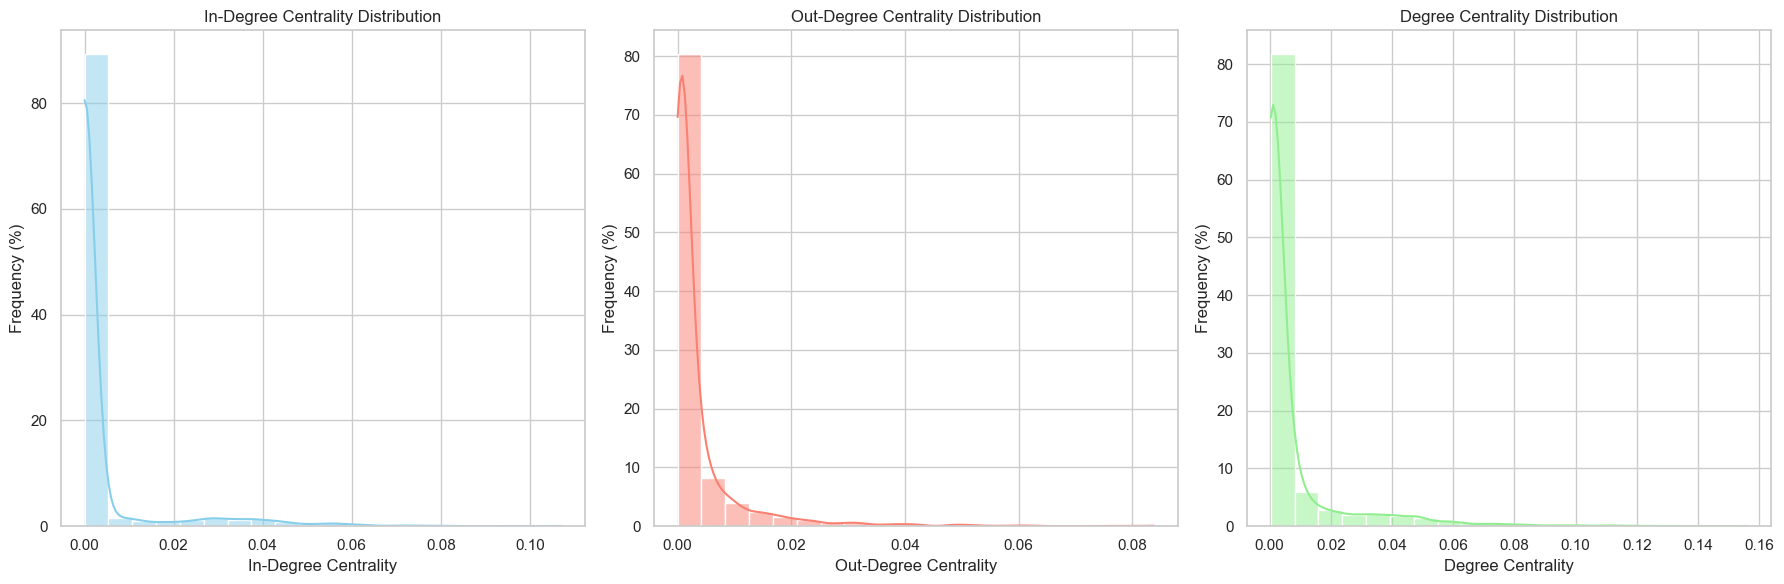

In [25]:
# Create the 'plots' directory if it doesn't exist
if not os.path.exists('plots'):
    os.makedirs('plots')

# Set up the plot figure
plt.figure(figsize=(18, 6))

# Plot the distribution of in-degree centrality (percentages)
plt.subplot(1, 3, 1)
sns.histplot(list(in_degree_centrality.values()), kde=True, bins=20, color='skyblue', stat='percent')
plt.title("In-Degree Centrality Distribution")
plt.xlabel("In-Degree Centrality")
plt.ylabel("Frequency (%)")

# Plot the distribution of out-degree centrality (percentages)
plt.subplot(1, 3, 2)
sns.histplot(list(out_degree_centrality.values()), kde=True, bins=20, color='salmon', stat='percent')
plt.title("Out-Degree Centrality Distribution")
plt.xlabel("Out-Degree Centrality")
plt.ylabel("Frequency (%)")

# Plot the distribution of degree centrality (percentages)
plt.subplot(1, 3, 3)
sns.histplot(list(degree_centrality.values()), kde=True, bins=20, color='lightgreen', stat='percent')
plt.title("Degree Centrality Distribution")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency (%)")

# Adjust the layout
plt.tight_layout()

# Save the plot to the 'plots' folder
plt.savefig('plots/centrality_distributions_percentage.png')


# Adjust the layout
plt.tight_layout()
plt.show()


### Betweeness Centrality

Betweenness centrality measures how often a node appears on the shortest path between other nodes. A high betweenness centrality indicates that the node acts as a bridge in the network - **it may not be a hub**.

In [26]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Sort nodes by betweenness centrality in descending order
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 hubs by betweenness centrality
print("Top 10 hubs by betweenness centrality:")
for node, centrality in sorted_betweenness_centrality[:10]:
    print(f"Node {node}: Betweenness Centrality = {centrality:.4f}")


Top 10 hubs by betweenness centrality:
Node HJ Mitchell: Betweenness Centrality = 0.0087
Node Boing! said Zebedee: Betweenness Centrality = 0.0080
Node Secret: Betweenness Centrality = 0.0077
Node Ktr101: Betweenness Centrality = 0.0071
Node Mkativerata: Betweenness Centrality = 0.0050
Node SarekOfVulcan: Betweenness Centrality = 0.0049
Node 28bytes: Betweenness Centrality = 0.0048
Node Fetchcomms: Betweenness Centrality = 0.0046
Node Lord Roem: Betweenness Centrality = 0.0044
Node Ironholds: Betweenness Centrality = 0.0042


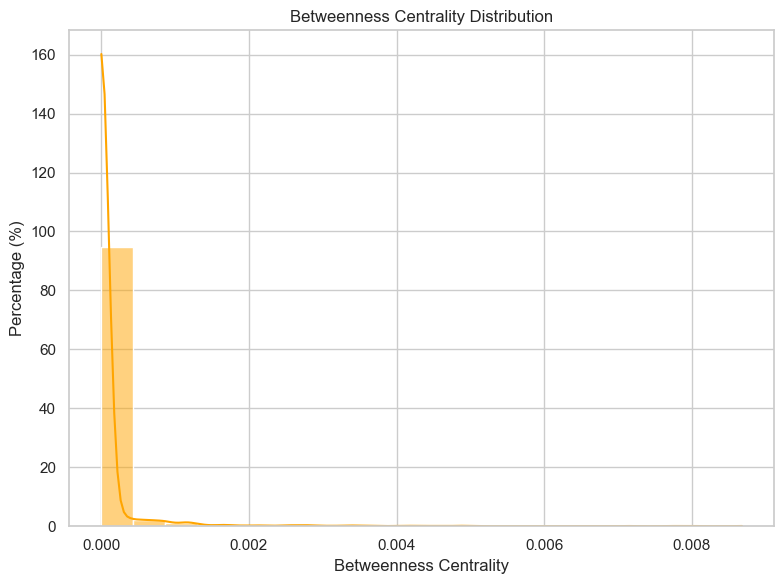

In [27]:
# Set up the plot for betweenness centrality
plt.figure(figsize=(8, 6))

# Plot the distribution of betweenness centrality (percentages)
sns.histplot(list(betweenness_centrality.values()), kde=True, bins=20, color='orange', stat='percent')
plt.title("Betweenness Centrality Distribution")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Percentage (%)")

# Save the plot to the 'plots' folder
plt.tight_layout()
plt.savefig('plots/betweenness_centrality_distribution_percentage.png')

# Adjust the layout
plt.tight_layout()
plt.show()

### Eigenvector Centrality

Eigenvector centrality is based on the idea that a node's importance is determined not only by its degree but also by the importance of the nodes it is connected to. High eigenvector centrality nodes are well-connected to other important nodes.

In [28]:
# its not implementable in multigraphs

# putting it in a simple network would lose too much information


### Closeness Centrality

Closeness centrality measures how close a node is to all other nodes in the network. A node with high closeness centrality is able to reach other nodes in fewer steps.



In [29]:
# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Sort nodes by closeness centrality in descending order
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 hubs by closeness centrality
print("Top 10 hubs by closeness centrality:")
for node, centrality in sorted_closeness_centrality[:10]:
    print(f"Node {node}: Closeness Centrality = {centrality:.4f}")


Top 10 hubs by closeness centrality:
Node SarahStierch: Closeness Centrality = 0.3804
Node HJ Mitchell: Closeness Centrality = 0.3782
Node Berean Hunter: Closeness Centrality = 0.3748
Node Lord Roem: Closeness Centrality = 0.3745
Node Ironholds: Closeness Centrality = 0.3736
Node Secret: Closeness Centrality = 0.3729
Node My76Strat: Closeness Centrality = 0.3697
Node SarekOfVulcan: Closeness Centrality = 0.3695
Node The Thing That Should Not Be: Closeness Centrality = 0.3671
Node Σ: Closeness Centrality = 0.3649


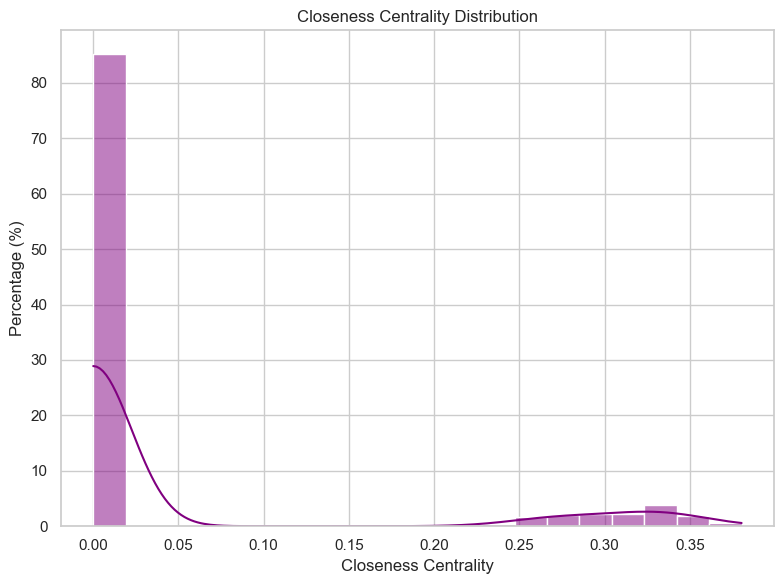

In [30]:
# Set up the plot for closeness centrality
plt.figure(figsize=(8, 6))

# Plot the distribution of closeness centrality (percentages)
sns.histplot(list(closeness_centrality.values()), kde=True, bins=20, color='purple', stat='percent')
plt.title("Closeness Centrality Distribution")
plt.xlabel("Closeness Centrality")
plt.ylabel("Percentage (%)")

# Save the plot to the 'plots' folder
plt.tight_layout()
plt.savefig('plots/closeness_centrality_distribution_percentage.png')

# Adjust the layout

plt.show()

### Random Failure vs Targeted Attacks through Centrality

- Random Failure: Nodes are removed randomly from the network, simulating random errors or failures.
- Targeted Attacks (Centrality): Nodes are removed based on their centrality (importance in the network), simulating deliberate attacks aimed at the most crucial nodes.


Precomputing centrality values improves efficiency by calculating them once, rather than recalculating for each node removal. This speeds up the simulation and ensures nodes are removed in a consistent, logical order based on their importance.

The results might be suboptimal but still have some similarity to the recompunting apon each removal

Simulating random failure...
Running attack for Degree centrality...
Running attack for Betweenness centrality...
Running attack for Closeness centrality...
Running attack for In-Degree centrality...
Running attack for Out-Degree centrality...


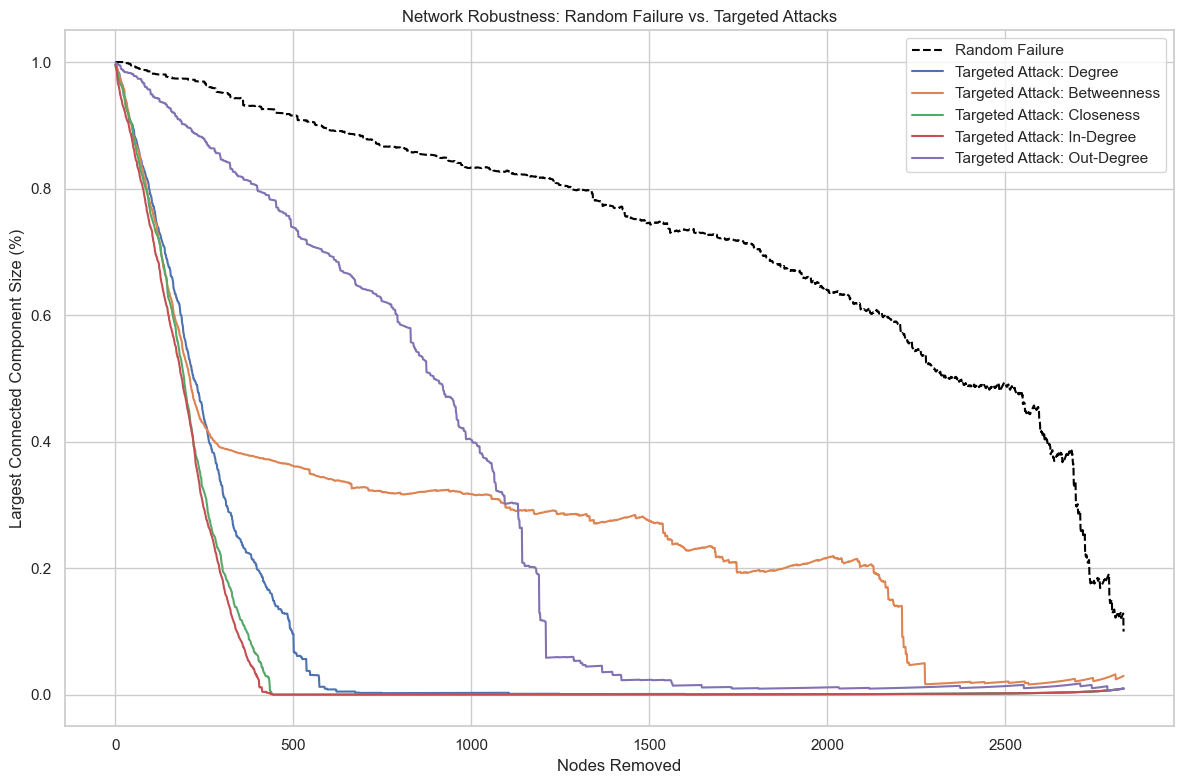

In [31]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns

def largest_connected_component_size(G):
    """
    Returns the size of the largest connected component in the graph (as a fraction of the total nodes).
    For a directed graph, we use weakly connected components.
    """
    if G.is_directed():
        connected_components = nx.weakly_connected_components(G)
    else:
        connected_components = nx.connected_components(G)
    
    largest_cc = max(connected_components, key=len)
    return len(largest_cc) / len(G.nodes)

def simulate_random_failure(G, target_size):
    """
    Simulates random failure by removing nodes randomly and records the largest connected component size.
    """
    G_copy = G.copy()
    sizes = []
    
    # Efficient random failure: shuffle the nodes and remove them one by one
    nodes_to_remove = list(G_copy.nodes)
    random.shuffle(nodes_to_remove)
    
    # Only perform one random failure simulation
    for node in nodes_to_remove:
        G_copy.remove_node(node)
        sizes.append(largest_connected_component_size(G_copy))
        if len(G_copy.nodes) <= target_size:
            break
    
    return sizes

def simulate_targeted_attack(G, centrality_function, target_size):
    """
    Simulates targeted attack by removing the most central nodes first.
    """
    G_copy = G.copy()
    sizes = []
    
    # Precompute centrality values once
    centrality = centrality_function(G_copy)
    
    # Sort nodes by centrality (highest to lowest)
    sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    nodes_to_remove = [node for node, _ in sorted_nodes]
    
    for node in nodes_to_remove:
        G_copy.remove_node(node)
        sizes.append(largest_connected_component_size(G_copy))
        if len(G_copy.nodes) <= target_size:
            break
    
    return sizes

def plot_robustness_comparison(random_result, targeted_results, labels):
    # Set Seaborn style
    
    
    # Create a figure with seaborn
    plt.figure(figsize=(12, 8))

    # Plot random result (single plot)
    plt.plot(range(len(random_result)), random_result, label="Random Failure", linestyle="--", color="black")
    
    # Plot targeted attack results
    for result, label in zip(targeted_results, labels):
        plt.plot(range(len(result)), result, label=f"Targeted Attack: {label}")
    
    # Add labels, title, and legend
    plt.title("Network Robustness: Random Failure vs. Targeted Attacks")
    plt.xlabel("Nodes Removed")
    plt.ylabel("Largest Connected Component Size (%)")
    plt.legend()

    # Display plot with tight layout
    plt.tight_layout()
    plt.savefig('plots/NetworkRobustness_RandomVSTargeted.png')
    plt.show()

# Set the target number of nodes (e.g., stop when there are fewer than 100 nodes)
target_size = 100

# Centrality functions to be used in targeted attacks
centrality_functions = [
    ('Degree', nx.degree_centrality),
    ('Betweenness', nx.betweenness_centrality),
    ('Closeness', nx.closeness_centrality),
    ('In-Degree', nx.in_degree_centrality),
    ('Out-Degree', nx.out_degree_centrality)
]

random_results = []
targeted_results = []

# Run the attack simulations for each centrality
print("Simulating random failure...")
random_result = simulate_random_failure(G, target_size)
random_results.append(random_result)

# Run the targeted attacks
for label, centrality_function in centrality_functions:
    print(f"Running attack for {label} centrality...")
    
    # Simulate targeted attack
    targeted_result = simulate_targeted_attack(G, centrality_function, target_size)
    targeted_results.append(targeted_result)

# Plot the results using seaborn
plot_robustness_comparison(random_result, targeted_results, [label for label, _ in centrality_functions])


### Partitions and Communities in Network Analysis

### Partitions

A **partition** is a way of dividing the nodes in a network into non-overlapping subsets or groups. Each subset in the partition represents a collection of nodes that are grouped based on certain criteria, often based on their connectivity or other network characteristics.

- **Non-overlapping partition**: Each node belongs to exactly one group.
- **Overlapping partition**: A node can belong to more than one group.

The goal of partitioning is to **minimise the number of edges between different partitions** (or to maximise the edges within the same partition), which indicates that nodes within the same partition are more strongly connected than nodes in different partitions.

#### Types of Partitions:

- **Modular Partitioning**: A method of dividing the network to maximise the number of edges within each group, often evaluated by modularity.
- **Spectral Partitioning**: Uses eigenvalues of the graph's Laplacian matrix to divide the network into partitions.
- **Hierarchical Partitioning**: Successively splits the network into smaller partitions (or clusters), creating a hierarchical tree structure.

### Communities

A **community** is a subset of nodes within a network that is **more densely connected to each other** than to the rest of the network. Communities in networks often reflect **functional, social, or organizational groupings**.

#### Characteristics of Communities:

- **Dense internal connections**: Nodes within the same community are tightly interconnected. (high cohesion)
- **Sparse external connections**: Communities are loosely connected to nodes outside their community. (high seperation)
- **Overlap (for overlapping communities)**: Some nodes might belong to multiple communities, especially in complex networks where individuals (nodes) have more than one role or association.


#### Key Similaraty Concepts to Partitions and Communities

1. **Modularity**: 
   - Modularity is a measure used to evaluate the quality of a partition or community structure. It quantifies the density of edges within communities compared to edges between communities. Higher modularity values indicate a better community structure, where nodes in the same community are more connected than nodes in different communities.

2. **Homophily**: 
   - The principle that similar nodes (e.g., nodes with similar attributes) are more likely to be connected. This often drives the formation of communities.

3. **Edge Density**:
   - The number of edges within a community compared to the total possible number of edges. Higher edge density suggests stronger internal connections within the community.

4. **Cliques**:
   - A clique is a subset of nodes in which every pair of nodes is connected by an edge. A clique can be seen as a very tightly knit community where every node is directly connected to every other node.



#### Community Detection in Social Networks

In **social networks**, community detection is crucial for understanding how individuals or groups interact, form relationships, or share common interests. Social networks are often complex and dynamic, with overlapping communities that evolve over time. Identifying these communities can help uncover hidden structures in social systems and offer insights into user behavior, group dynamics, and influence patterns.

#### Recommended Approach for Social Networks:

1. **Louvain Algorithm - Non-overlapping communities**:
- It's widely used for community detection in social networks. It maximizes the **modularity** of the network, which helps identify dense clusters of nodes that are highly connected internally but sparsely connected to other clusters. This method is efficient and scalable, making it a good choice for large social networks.


2. **BigClam - Overllaping communities**:
- Social networks often have overlapping communities, where individuals belong to multiple groups (e.g., professional, social, hobby-based). The **BigClam algorithm** is particularly effective for detecting overlapping communities, making it suitable for social networks with complex relationships.





### Louvain Algorithm HIerarchical- multiple iterations for optimised results

NOT OPTIMAL ANSWERS 

The **Louvain Community Detection Algorithm** is a simple method used to extract the community structure of a network. It is a heuristic method based on **modularity optimization**.

The algorithm works in two steps:

#### Step 1: Assigning Nodes to Communities

In the first step, every node is assigned to its own community. Then, for each node, the algorithm tries to find the maximum positive modularity gain by moving each node to one of its neighbor communities. If no positive gain is achieved, the node remains in its original community.

The modularity gain obtained by moving an isolated node into a community can be easily calculated by the following formula:

$$
\Delta Q = \frac{e_{\text{in}}}{2m} - \left( \frac{k_i}{2m} \right) \cdot \left( \frac{k_j}{2m} \right)
$$

Where:
- $ e_{\text{in}} $ is the sum of the weights of the links between node $ i $ and the nodes in community $ C_j $,
- $ k_i $ is the sum of the weights of the links incident to node $ i $,
- $ k_j $ is the sum of the weights of the links incident to community $ C_j $,
- $ m $ is the size of the graph,
- $ C_j $ is the community to which node $ i $ is trying to move.

##### Directed Case Modularity Gain

For directed graphs, the modularity gain can be computed using the following formula:

$$
\Delta Q = \frac{e_{\text{in}}^{\text{in}}}{2m} - \left( \frac{k_{\text{in}}}{2m} \right) \cdot \left( \frac{k_{\text{out}}}{2m} \right)
$$

Where:
- $ e_{\text{in}}^{\text{in}}$ is the inner weighted degree of node $ i $,
- $ k_{\text{in}} $ is the sum of in-going links incident to node $ i $,
- $ k_{\text{out}} $ is the sum of out-going links incident to node $ i $,
- $ m $ is the size of the graph.

#### Step 2: Building a New Network

In the second phase, a new network is built where the nodes are the communities found in the first phase. The weights of the links between the new nodes are given by the sum of the weights of the links between nodes in the corresponding two communities. Once this phase is complete, the first phase can be re-applied, creating larger communities with increased modularity.

#### Termination

The above two phases are executed iteratively until no modularity gain is achieved (or the gain is less than a threshold, or the maximum number of levels is reached).

#### Self-loops

Be careful with **self-loops** in the input graph. These are treated as if the process had already started in the middle of the algorithm. Large self-loop edge weights represent strong communities, making it difficult to add other nodes. If your input graph's self-loop edge weights do not represent already reduced communities, you may want to remove the self-loops before inputting the graph.


### Louvain Modularity Clustering

In [14]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
from collections import Counter
from networkx.algorithms.community import modularity, partition_quality


def louvain_community_detection_directed(G, iterations=50):
    """
    Perform community detection using the Louvain method on a directed graph by collapsing directed edges into undirected edges 
    for the purpose of community detection. The graph remains directed for further analysis.

    Parameters:
        G (nx.MultiDiGraph): The input directed graph.
        iterations (int): The number of iterations to perform for detecting the best community partition.

    Returns:
        best_partition (dict): A dictionary where keys are node IDs and values are community IDs.
        best_modularity (float): The highest modularity value from the iterations.
        community_sizes (Counter): Sizes of communities in the best partition.
        coverage (float): Coverage score of the partitioning.
        performance (float): Performance score of the partitioning.
        conductance_score (float): Conductance score of the partitioning.
    """
    best_partition = None
    best_modularity = -1  # Start with a low modularity value
    best_partition_dict = None  # Store the partition dictionary

    # Convert directed graph to an undirected graph for community detection
    simple_G = nx.DiGraph()  # Use an undirected graph here
    for u, v in G.edges():
        simple_G.add_edge(u, v)  # Collapse directed edges into undirected edges
    
    # Perform multiple iterations to find the partition with the highest modularity
    for _ in range(iterations):
        # Apply Louvain method for community detection using NetworkX
        communities = list(louvain_communities(simple_G))
        
        # Create a partition mapping: node -> community ID
        partition = {}
        for community_id, community in enumerate(communities):
            for node in community:
                partition[node] = community_id
        
        # Calculate modularity for the partition
        modularity_score = modularity(simple_G, communities)
        
        # Calculate coverage and performance
        coverage, performance = partition_quality(simple_G, communities)
        
        # Calculate conductance for each pair of communities (here we will use the first two communities)
        if len(communities) > 1:
            conductance_score = nx.conductance(simple_G, communities[0], communities[1])
        else:
            conductance_score = 0  # If there is only one community, the conductance is 0
        
        # Check if the current modularity is better
        if modularity_score > best_modularity:
            best_modularity = modularity_score
            best_partition_dict = partition

    # Create a Counter for community sizes in the best partition
    community_sizes = Counter(best_partition_dict.values())

    return best_partition_dict, best_modularity, community_sizes, coverage, performance, conductance_score


# Example of applying the function on your MultiDiGraph G
partition, modularity, community_sizes, coverage, performance, conductance_score = louvain_community_detection_directed(G)

print("Best Modularity:", modularity)
print(f"Community sizes: {community_sizes}")
print(f"Coverage: {coverage:.4f}")
print(f"Performance: {performance:.4f}")
print(f"Conductance: {conductance_score:.4f}")


Best Modularity: 0.3257010251960635
Community sizes: Counter({1: 850, 3: 732, 0: 725, 2: 627})
Coverage: 0.6121
Performance: 0.7172
Conductance: 0.4955


### Naive greedy modularity maximisation

In [13]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import modularity, partition_quality
from collections import Counter

def detect_and_measure_communities(G, iterations=10):
    """
    Detect communities using naive greedy modularity maximisation over multiple iterations,
    and evaluate the partition quality.

    Parameters:
        G (nx.MultiDiGraph): Input graph.
        iterations (int): Number of iterations to perform for detecting the best community partition.

    Returns:
        best_partition (dict): A dictionary where keys are node IDs and values are community IDs.
        best_modularity (float): The highest modularity value from the iterations.
        community_sizes (Counter): Sizes of the communities in the best partition.
        coverage (float): Coverage score of the best partitioning.
        performance (float): Performance score of the best partitioning.
        best_conductance (float): Conductance score of the best partitioning.
    """
    best_modularity = -1  # Start with a low modularity value
    best_partition = None
    best_community_sizes = None
    best_coverage = None
    best_performance = None
    best_conductance = None
    
    # Convert MultiDiGraph to a simple undirected graph (no weights)
    simple_G = nx.DiGraph()
    for u, v in G.edges():
        simple_G.add_edge(u, v)  # No weight handling

    # Perform multiple iterations to find the best partition based on modularity
    for _ in range(iterations):
        # Detect communities using greedy modularity maximisation
        communities = list(greedy_modularity_communities(simple_G))
        
        # Convert communities into a partition (list of sets of nodes)
        partition = [set(community) for community in communities]
        
        # Compute modularity
        modularity_score = modularity(simple_G, partition)
        
        # Compute coverage and performance
        coverage, performance = partition_quality(simple_G, partition)
        
        # Compute conductance for the first two communities (if available)
        if len(communities) > 1:
            conductance_score = nx.conductance(simple_G, communities[0], communities[1])
        else:
            conductance_score = 0  # If there is only one community, conductance is 0
        
        # Update the best partition based on modularity
        if modularity_score > best_modularity:
            best_modularity = modularity_score
            
            # Create a dictionary mapping node -> community
            best_partition = {}
            for community_id, community in enumerate(communities):
                for node in community:
                    best_partition[node] = community_id

            # Track the community sizes (same format as Louvain output)
            best_community_sizes = Counter(best_partition.values())
            
            # Update other metrics
            best_coverage = coverage
            best_performance = performance
            best_conductance = conductance_score

    # Return the best partition, modularity, community sizes, coverage, performance, and conductance
    return best_partition, best_modularity, best_community_sizes, best_coverage, best_performance, best_conductance


# Example of applying the function on your MultiDiGraph G
best_partition, best_modularity, best_community_sizes, best_coverage, best_performance, best_conductance = detect_and_measure_communities(G)

# Print results
print(f"Best Modularity: {best_modularity:.4f}")
print(f"Community sizes: {best_community_sizes}")
print(f"Coverage: {best_coverage:.4f}")
print(f"Performance: {best_performance:.4f}")
print(f"Conductance: {best_conductance:.4f}")


Best Modularity: 0.3046
Community sizes: Counter({0: 1244, 1: 1151, 2: 529, 3: 6, 4: 4})
Coverage: 0.6842
Performance: 0.6353
Conductance: 0.3397


### BigCLAM

import pandas as pd
import numpy as np
import networkx as nx

# BigClam Functions
def sigm(x):
    """ Sigmoid function """
    return 1.0 / (1.0 + np.exp(-x))  # Correct sigmoid formula

def log_likelihood(F, A):
    """ Log-likelihood calculation """
    A_soft = F.dot(F.T)  # Matrix multiplication to get soft similarity scores
    A_soft = np.clip(A_soft, -700, 700)  # Avoid overflow in exp and log calculations
    FIRST_PART = A * np.log(1.0 - np.exp(-A_soft))  # Connection terms (A = 1 for edges)
    sum_edges = np.sum(FIRST_PART)
    
    SECOND_PART = (1 - A) * A_soft  # Non-connection terms (A = 0 for non-edges)
    sum_nedges = np.sum(SECOND_PART)
    
    return sum_edges - sum_nedges  # Log-likelihood value

def gradient(F, A, node_idx):
    """ Gradient calculation for node_idx """
    N, C = F.shape
    neighbours = np.where(A[node_idx])[0]  # Nodes connected to node_idx
    nneighbours = np.where(1 - A[node_idx])[0]  # Nodes not connected to node_idx
    
    sum_neigh = np.zeros((C,))
    for nb in neighbours:
        dotproduct = F[nb].dot(F[node_idx])  # Dot product for community update
        sum_neigh += F[nb] * sigm(dotproduct)  # Gradients from neighbors

    sum_nneigh = np.zeros((C,))
    for nnb in nneighbours:
        sum_nneigh += F[nnb]  # Gradients from non-neighbors

    return sum_neigh - sum_nneigh  # Gradient for the node_idx

def train(A, C, iterations=100, learning_rate=0.005, decay_rate=0.99):
    """ Train BigClam model with learning rate decay """
    N = A.shape[0]
    F = np.random.rand(N, C)  # Initialize random community membership for each node

    # Training loop
    for n in range(iterations):
        for node_idx in range(N):  # Iterate over each node in the graph
            grad = gradient(F, A, node_idx)  # Compute gradient for node_idx
            F[node_idx] += learning_rate * grad  # Update feature matrix `F` based on gradient
            F[node_idx] = np.maximum(0.001, F[node_idx])  # Ensure non-negative membership values

        # Decay the learning rate over time
        learning_rate *= decay_rate

        ll = log_likelihood(F, A)  # Calculate log-likelihood
        print(f"At step {n + 1}/{iterations}, log-likelihood is {ll:.3f}")
    
    return F



def graph_to_multigraph(data):
    """ Convert data to adjacency matrix for a multigraph """
    G = nx.MultiGraph()  # Use MultiGraph for multiple edges between nodes
    
    # Add nodes from SRC and TGT
    for _, row in data.iterrows():
        G.add_node(row['SRC'])
        G.add_node(row['TGT'])
    
    # Add edges with weights (VOT) to the graph
    for _, row in data.iterrows():
        G.add_edge(row['SRC'], row['TGT'], weight=row['VOT'])

    return G

def multigraph_to_adjacency_matrix(G, nodes):
    """ Convert the multigraph to an adjacency matrix, summing weights of multiple edges """
    N = len(nodes)
    adj_matrix = np.zeros((N, N))

    node_index = {node: idx for idx, node in enumerate(nodes)}
    
    for node1, node2, data in G.edges(data=True):
        idx1 = node_index[node1]
        idx2 = node_index[node2]
        adj_matrix[idx1, idx2] += data['weight']  # Sum the weights of multiple edges

    return adj_matrix


# Get the list of nodes (users)
users = list(G.nodes)

# Convert multigraph to adjacency matrix
A = multigraph_to_adjacency_matrix(G, users)

# Define number of communities
C = 4  # Number of communities

# Train the BigClam model
F = train(A, C)

# Assign nodes to communities
communities = {users[i]: np.argmax(F[i]) for i in range(len(users))}

# Output the detected communities
print("Detected Communities:")
for node, community in communities.items():
    print(f"Node {node}: Community {community}")


### Coverage, Performance, and Conductance in Community Detection

#### 1. **Coverage**
   - **Definition**: Coverage measures the fraction of edges that are within communities, compared to the total number of edges in the graph.
   - **Interpretation**: A higher coverage indicates that the communities identified by the algorithm are tightly connected internally, meaning most edges are within the same community.
   - **Formula**:
     $$
     \text{Coverage} = \frac{\text{Number of edges within communities}}{\text{Total number of edges in the graph}}
     $$

#### 2. **Performance**
   - **Definition**: Performance measures the number of edges between communities. It reflects how well the community detection algorithm has separated different communities.
   - **Interpretation**: A higher performance means that fewer edges cross between communities, indicating clear separation between the communities.
   - **Formula**:
     $$
     \text{Performance} = \frac{\text{Number of edges between different communities}}{\text{Total number of edges in the graph}}
     $$

#### 3. **Conductance**
   - **Definition**: Conductance measures the fraction of the total edge weight that crosses the boundary of a community, relative to the total edge weight of that community.
   - **Interpretation**: A lower conductance means that the community is well-defined, with fewer connections to nodes outside the community. High conductance indicates that a community has many edges leading outside, suggesting weak community structure.
   - **Formula**:
     $$
     \text{Conductance}(C) = \frac{\text{Weight of edges from community } C \text{ to outside}}{\text{Total edge weight in community } C}
     $$


### Spectral Clustering 

## Text Analysis

The values produced by the TfidfVectorizer in your analysis represent the **TF-IDF scores** (Term Frequency-Inverse Document Frequency) for each term (unigram, bigram, or trigram) in your dataset. These scores help you understand the relative importance of each term within the context of the entire corpus (your collection of comments or texts). Here's a breakdown of what these values mean:

#### **TF-IDF (Term Frequency-Inverse Document Frequency)**

- **Term Frequency (TF)**: Measures how often a term (word, bigram, trigram) appears in a document.
    - For a specific term, the higher its frequency in a document, the higher its TF score.

- **Inverse Document Frequency (IDF)**: Measures how important a term is across all documents in the corpus.
    - The more documents a term appears in, the lower its IDF score (it becomes less informative).
    - Terms that appear in very few documents have a higher IDF score, as they are considered more "unique" or "specific" to certain documents.

- **TF-IDF** combines both measures:
    - High TF and low IDF = High TF-IDF (important for that document).
    - High TF and high IDF = Moderate TF-IDF (appears often, but not special).
    - Low TF and low IDF = Low TF-IDF (appears rarely and in many documents).


In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Instanciate Lemmetizer
lmtzr = WordNetLemmatizer()
stop_words = set(stopwords.words('english') + ['support', 'oppose', 'user', 'admin', 'candidate', 'wikipedia', 'color',
                                              'http', 'php', 'org', 'luck', 'font', 'see', 'green', 'would', 'e', 'span', 'style', 'border', '1px', 'index' ])

# Function to get text in desired lowercase form
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

# Function for different forms of tokeniztion (all 3 forms tested for performace)
def tokenize(words, modulation):
    tokens = re.split(r'\W+', words)
    stems = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers=abbr_or_lower(token)
        if lowers not in stop_words:
            if re.search('[a-zA-Z]', lowers):
                if modulation==1:
                    stems.append(porter.stem(lowers))
                if modulation==2:
                    stems.append(lmtzr.lemmatize(lowers))
                if modulation==0:
                    stems.append(lowers)
    return stems

#### Text Analysis - VOT 1

In [37]:
# Ensure that the 'text' is in string format and handle NaN values by replacing them with an empty string
text = df['TXT'].fillna('').astype(str)  # Fill NaNs with empty string and convert to string

# Separate rows where VOT is 1
df_vot_1 = df[df['VOT'] == 1]

# Apply Pre-Processing and Tokenization for VOT = 1
comments_vot_1 = [tokenize(comment, 2) for comment in df_vot_1['TXT'].fillna('').astype(str)]  # Modulation = 2 for lemmatization

# Instantiate TF-IDF Vectorizers
tfidf1 = TfidfVectorizer(ngram_range=(1, 1), tokenizer=lambda doc: doc, lowercase=False)  # Unigrams
tfidf2 = TfidfVectorizer(ngram_range=(2, 2), tokenizer=lambda doc: doc, lowercase=False)  # Bigrams
tfidf3 = TfidfVectorizer(ngram_range=(3, 3), tokenizer=lambda doc: doc, lowercase=False)  # Trigrams

# TF-IDF for VOT = 1 (Unigrams)
com_uni_vot_1 = tfidf1.fit_transform(comments_vot_1)

# Convert the results into a DataFrame for better readability
uni_df_vot_1 = pd.DataFrame.sparse.from_spmatrix(com_uni_vot_1, columns=tfidf1.get_feature_names_out())
uni_df_vot_1 = uni_df_vot_1.sum(axis=0)  # Sum across all documents (rows)
uni_df_vot_1 = uni_df_vot_1.sort_values(axis=0, ascending=False)  # Sort by frequency
print("Top 10 Unigrams for VOT = 1:")
print(uni_df_vot_1.head(10))

# TF-IDF for VOT = 1 (Bigrams)
com_bi_vot_1 = tfidf2.fit_transform(comments_vot_1)
bi_df_vot_1 = pd.DataFrame.sparse.from_spmatrix(com_bi_vot_1, columns=tfidf2.get_feature_names_out())
bi_df_vot_1 = bi_df_vot_1.sum(axis=0)
bi_df_vot_1 = bi_df_vot_1.sort_values(axis=0, ascending=False)
print("\nTop 10 Bigrams for VOT = 1:")
print(bi_df_vot_1.head(10))

# TF-IDF for VOT = 1 (Trigrams)
com_tri_vot_1 = tfidf3.fit_transform(comments_vot_1)
tri_df_vot_1 = pd.DataFrame.sparse.from_spmatrix(com_tri_vot_1, columns=tfidf3.get_feature_names_out())
tri_df_vot_1 = tri_df_vot_1.sum(axis=0)
tri_df_vot_1 = tri_df_vot_1.sort_values(axis=0, ascending=False)
print("\nTop 10 Trigrams for VOT = 1:")
print(tri_df_vot_1.head(10))

Top 10 Unigrams for VOT = 1:
good       940.962937
concern    493.400174
editor     476.937421
reason     467.913914
tool       446.944922
per        404.138276
look       390.848795
great      383.770804
work       380.768012
seems      337.446804
dtype: Sparse[float64, 0]

Top 10 Bigrams for VOT = 1:
look good            193.320975
answer question      125.385094
net positive         125.360976
abuse tool            115.43922
fully qualified       92.879319
reason think          85.855374
per nom               81.768437
good answer           71.545769
good contribution     69.746371
good work             68.331263
dtype: Sparse[float64, 0]

Top 10 Trigrams for VOT = 1:
wizardman wizardman sub    75.387432
think abuse tool           62.500134
reason think abuse         62.253458
family georgia size        43.716406
good answer question       38.305014
king heart king            36.748945
face comic sans            36.489219
comic sans MS                36.2407
en w title              

#### Text Analysis - VOT -1



In [38]:
# Separate rows where VOT is -1
df_vot_neg_1 = df[df['VOT'] == -1]

# Apply Pre-Processing and Tokenization for VOT = -1
comments_vot_neg_1 = [tokenize(comment, 2) for comment in df_vot_neg_1['TXT'].fillna('').astype(str)]  # Modulation = 2 for lemmatization

# TF-IDF for VOT = -1 (Unigrams)
com_uni_vot_neg_1 = tfidf1.fit_transform(comments_vot_neg_1)

# Convert the results into a DataFrame for better readability
uni_df_vot_neg_1 = pd.DataFrame.sparse.from_spmatrix(com_uni_vot_neg_1, columns=tfidf1.get_feature_names_out())
uni_df_vot_neg_1 = uni_df_vot_neg_1.sum(axis=0)  # Sum across all documents (rows)
uni_df_vot_neg_1 = uni_df_vot_neg_1.sort_values(axis=0, ascending=False)  # Sort by frequency
print("\nTop 10 Unigrams for VOT = -1:")
print(uni_df_vot_neg_1.head(10))

# TF-IDF for VOT = -1 (Bigrams)
com_bi_vot_neg_1 = tfidf2.fit_transform(comments_vot_neg_1)
bi_df_vot_neg_1 = pd.DataFrame.sparse.from_spmatrix(com_bi_vot_neg_1, columns=tfidf2.get_feature_names_out())
bi_df_vot_neg_1 = bi_df_vot_neg_1.sum(axis=0)
bi_df_vot_neg_1 = bi_df_vot_neg_1.sort_values(axis=0, ascending=False)
print("\nTop 10 Bigrams for VOT = -1:")
print(bi_df_vot_neg_1.head(10))

# TF-IDF for VOT = -1 (Trigrams)
com_tri_vot_neg_1 = tfidf3.fit_transform(comments_vot_neg_1)
tri_df_vot_neg_1 = pd.DataFrame.sparse.from_spmatrix(com_tri_vot_neg_1, columns=tfidf3.get_feature_names_out())
tri_df_vot_neg_1 = tri_df_vot_neg_1.sum(axis=0)
tri_df_vot_neg_1 = tri_df_vot_neg_1.sort_values(axis=0, ascending=False)
print("\nTop 10 Trigrams for VOT = -1:")
print(tri_df_vot_neg_1.head(10))


Top 10 Unigrams for VOT = -1:
per           268.967753
experience    220.053508
concern       160.284403
WP            150.097464
answer          133.4174
edits         131.110098
sorry          124.82674
article        123.62526
question      123.546174
work          121.364705
dtype: Sparse[float64, 0]

Top 10 Bigrams for VOT = -1:
WP NOTNOW            58.911668
en w                 55.495846
w title              55.489467
answer question      47.855689
enough experience    34.408985
per WP               32.470113
118em 118em          31.101188
lack experience      27.107877
talk page            26.877485
diff oldid            26.79843
dtype: Sparse[float64, 0]

Top 10 Trigrams for VOT = -1:
en w title             52.735962
per WP NOTNOW          24.750914
diff prev oldid        24.532923
w title user_talk      17.380411
text shadow grey       16.473176
118em class texhtml    15.320992
shadow grey 118em      15.320992
118em 118em class      15.320992
118em 118em 118em      15.320992

In [39]:
# Filter rows where both 'NOTNOW' and 'WP' are found within the 'TXT' column
filtered_result = df[df['TXT'].str.contains('NOTNOW', case=False, na=False) & df['TXT'].str.contains('WP', case=False, na=False)]
filtered_result

,SRC,TGT,VOT,RES,YEA,DAT,TXT
2397,Ultraexactzz,angelo1345,-1,-1,2013,2013-04-09 13:09:00,''''''. I don't think the problem with your En...
2400,Jasper Deng,AppleJack-7,-1,-1,2013,2013-06-03 02:57:00,'''''' per [[WP:NOTNOW]]. Feel free to try aga...
3301,Tazerdadog,TortoiseWrath,1,-1,2013,2013-03-07 04:12:00,"'''Moral ''', while this is probably about to ..."
5056,Trevj,KTC,-1,1,2012,2012-12-21 14:38:00,'''''' (moved from ''neutral'') <del>per [[WP:...
6708,Rschen7754,987li,-1,-1,2012,2012-04-24 09:15:00,[[WP:NOTNOW]]. --'''
...,...,...,...,...,...,...,...
30109,Salvio giuliano,WikiCopter,-1,-1,2010,2010-09-13 10:30:00,"''''''. You're a very good editor, but I'm sor..."
30110,Chzz,WikiCopter,-1,-1,2010,2010-09-13 11:11:00,"''''''[[WP:NOTNOW]] <small><span style=""border..."
30233,Kudpung,Youndbuckerz,-1,-1,2010,2010-06-14 01:30:00,'''''' - I would suggest closure per [[WP:NOT...
30237,Mkativerata,Yuvmil,-1,-1,2010,2010-03-20 22:40:00,''''''. [[WP:NOTNOW]]. Only 43 edits is not en...


## Predicting Edges

### Balance Theory

In [96]:
def predict_balance(G):
    """
    Predicts labels (-1 or 1) for existing edges based on Balance Theory.

    Parameters:
        G (nx.MultiDiGraph): The input graph.

    Returns:
        predictions (dict): Dictionary of predicted labels for edges.
    """
    predictions = {}

    for u, v, edge_data in G.edges(data=True):
        if 'label' not in edge_data:
            continue  # Skip edges without a 'label' attribute

        # Find common neighbours (triads)
        common_neighbours = set(G.neighbors(u)).intersection(set(G.neighbors(v)))
        
        balanced_positive = 0
        balanced_negative = 0
        
        for w in common_neighbours:
            try:
                # Access the 'label' attribute of edges forming the triad
                u_w = G[u][w][0]['label']
                v_w = G[v][w][0]['label']
            except KeyError:
                continue  # Skip if the edge or label is missing
            
            # Check triad balance
            if u_w == 1 and v_w == 1:
                balanced_positive += 1  # u -> w -> v is positive
            elif u_w == -1 and v_w == -1:
                balanced_positive += 1  # u -> w -> v is positive
            elif (u_w == 1 and v_w == -1) or (u_w == -1 and v_w == 1):
                balanced_negative += 1  # u -> w -> v is negative
        
        # Predict edge label
        if balanced_positive > balanced_negative:
            predictions[(u, v)] = 1
        elif balanced_positive < balanced_negative:
            predictions[(u, v)] = -1
        else:
            predictions[(u, v)] = edge_data['label']  # Keep the existing label if no clear prediction

    return predictions

# Predict edge labels
edge_predictions = predict_existing_edge_labels(G)
print(f"Number of predicted edge labels: {len(edge_predictions)}")

# Example: Print some predictions
for edge, prediction in list(edge_predictions.items())[:10]:
    print(f"Edge {edge}: Predicted label {prediction}")


Number of predicted edge labels: 29699
Edge ('Steel1943', 'BDD'): Predicted label 1
Edge ('Steel1943', 'Jasper Deng'): Predicted label -1
Edge ('BDD', 'Miniapolis'): Predicted label 1
Edge ('BDD', 'West.andrew.g'): Predicted label 1
Edge ('BDD', 'KumiokoCleanStart'): Predicted label 1
Edge ('BDD', 'Piotrus'): Predicted label 1
Edge ('Cuchullain', 'BDD'): Predicted label 1
Edge ('Cuchullain', 'Richwales'): Predicted label 1
Edge ('INeverCry', 'BDD'): Predicted label 1
Edge ('INeverCry', 'Bilby'): Predicted label 1


In [97]:
# Compare predictions to actual labels (if they exist)
correct_predictions = sum(1 for (u, v), pred in all_edge_predictions.items()
                          if G[u][v][0].get('label') == pred)
accuracy = correct_predictions / len(all_edge_predictions)
print(f"Accuracy of predictions: {accuracy:.2f}")


Accuracy of predictions: 0.53


### Status Theory

In [102]:
df

,text,label
0,Example text 1,1
1,Example text 2,-1
2,Example text 3,0


In [92]:
def predict_status(G):
    """
    Predicts labels (-1 or 1) for existing edges based on Status Theory.

    Parameters:
        G (nx.MultiDiGraph): The input graph.

    Returns:
        predictions (dict): Dictionary of predicted labels for edges.
    """
    predictions = {}

    for u, v, edge_data in G.edges(data=True):
        if 'label' not in edge_data:
            continue  # Skip edges without a 'label' attribute

        # Get node statuses
        status_u = G.nodes[u].get('status', 0)  # Default to 0 if no status assigned
        status_v = G.nodes[v].get('status', 0)

        # Predict based on Status Theory:
        # Positive edge (1) if u's status is greater than or equal to v's status
        # Negative edge (-1) otherwise
        if status_u >= status_v:
            predictions[(u, v)] = 1
        else:
            predictions[(u, v)] = -1

    return predictions


# Example usage:
# Ensure nodes have a 'status' attribute assigned before prediction
# You can assign statuses like this:
# for node in G.nodes:
#     G.nodes[node]['status'] = some_function_to_compute_status(node)

status_predictions = predict_status(G)
print(f"Predicted {len(status_predictions)} edge labels.")

# Example: Print a few predictions
for edge, prediction in list(status_predictions.items())[:10]:
    print(f"Edge {edge}: Predicted label {prediction}")


Predicted 29699 edge labels.
Edge ('Steel1943', 'BDD'): Predicted label -1
Edge ('Steel1943', 'Jasper Deng'): Predicted label -1
Edge ('BDD', 'Miniapolis'): Predicted label -1
Edge ('BDD', 'West.andrew.g'): Predicted label 1
Edge ('BDD', 'KumiokoCleanStart'): Predicted label 1
Edge ('BDD', 'Piotrus'): Predicted label 1
Edge ('Cuchullain', 'BDD'): Predicted label -1
Edge ('Cuchullain', 'Richwales'): Predicted label -1
Edge ('INeverCry', 'BDD'): Predicted label -1
Edge ('INeverCry', 'Bilby'): Predicted label -1


In [93]:
# Compare predictions to actual labels (if they exist)
correct_predictions = sum(1 for (u, v), pred in status_predictions.items()
                          if G[u][v][0].get('label') == pred)
accuracy = correct_predictions / len(status_predictions)
print(f"Accuracy of predictions (Status Theory): {accuracy:.2f}")


Accuracy of predictions (Status Theory): 0.32


### Sentiment Model

In [108]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
import pandas as pd

# Replace NaN and convert text to strings
df['TXT'] = df['TXT'].fillna('').astype(str)

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['TXT'].tolist(), df['VOT'].tolist(), test_size=0.2
)

# Ensure all texts are strings
train_texts = [str(text) for text in train_texts]
val_texts = [str(text) for text in val_texts]

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Dataset class
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Prepare datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

# Load model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()


ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


In [49]:
# Assign sentiment to edges
for _, row in df.iterrows():
    src, tgt, sentiment = row['SRC'], row['TGT'], row['sentiment']
    if G.has_edge(src, tgt):  # Check if edge exists
        for key in G[src][tgt]:  # Handle MultiDiGraph cases
            G[src][tgt][key]['sentiment'] = sentiment
    else:
        G.add_edge(src, tgt, sentiment=sentiment)

# Aggregate sentiment at the node level
node_sentiments = {}
for node in G.nodes():
    # Collect sentiments for edges connected to the node
    sentiments = [
        data.get('sentiment', 0)  # Default to 0 if 'sentiment' is not found
        for _, _, data in G.edges(node, data=True)
    ]
    # Calculate the average sentiment or set to 0 if no sentiments
    node_sentiments[node] = sum(sentiments) / len(sentiments) if sentiments else 0

# Set node attributes
nx.set_node_attributes(G, node_sentiments, 'node_sentiment')

# Check an edge's sentiment
edge_sample = list(G.edges(data=True))[0]
print(f"Sample edge sentiment: {edge_sample}")

# Check a node's aggregated sentiment
node_sample = list(G.nodes(data=True))[0]
print(f"Sample node sentiment: {node_sample}")


Sample edge sentiment: ('Steel1943', 'BDD', {'label': 1, 'txt': "'''''' as co-nom.", 'admin': 'admin', 'DAT': '2013-04-19 23:13:00', 'sentiment': 0.0})
Sample node sentiment: ('Steel1943', {'node_sentiment': 0.42195})


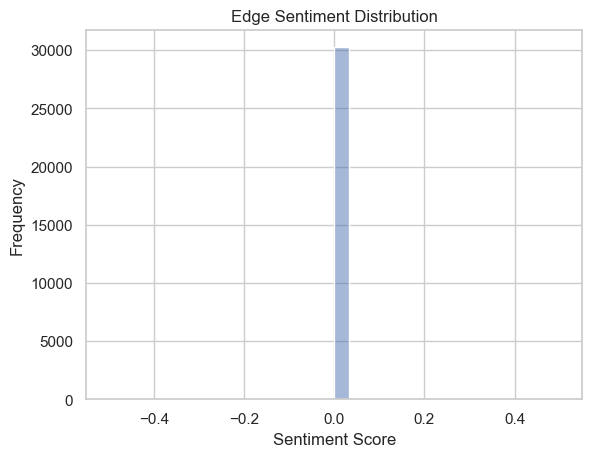

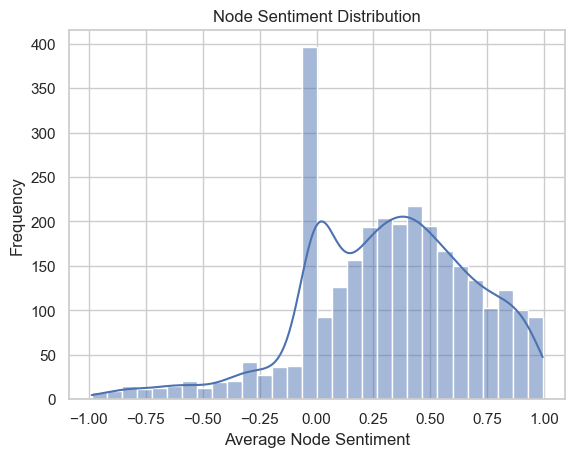

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Safely extract edge sentiments with a default value
edge_sentiments = [
    G[edge[0]][edge[1]].get('sentiment', 0)  # Default to 0 if 'sentiment' is missing
    for edge in G.edges()
]

# Plot sentiment histogram for edges
sns.histplot(edge_sentiments, kde=True, bins=30)
plt.title("Edge Sentiment Distribution")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

# Safely extract node sentiments
node_sentiments_list = list(node_sentiments.values())  # Use `node_sentiments` dictionary values

# Plot sentiment histogram for nodes
sns.histplot(node_sentiments_list, kde=True, bins=30)
plt.title("Node Sentiment Distribution")
plt.xlabel("Average Node Sentiment")
plt.ylabel("Frequency")
plt.show()


In [55]:
# Extract true labels and sentiment scores
true_labels = [data['label'] for _, _, data in G.edges(data=True)]  # True edge labels (-1 or 1)
predicted_labels = [
    1 if data.get('sentiment', 0) > 0 else -1
    for _, _, data in G.edges(data=True)
]  # Predicted edge labels based on sentiment


In [56]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Classification report
print(classification_report(true_labels, predicted_labels, target_names=["-1", "1"]))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# ROC-AUC score (if using sentiment scores directly for prediction probabilities)
sentiment_scores = [data.get('sentiment', 0) for _, _, data in G.edges(data=True)]
roc_auc = roc_auc_score(true_labels, sentiment_scores)
print(f"ROC-AUC Score: {roc_auc:.2f}")


              precision    recall  f1-score   support

          -1       0.34      0.53      0.41      7217
           1       0.82      0.68      0.74     23035

    accuracy                           0.64     30252
   macro avg       0.58      0.60      0.58     30252
weighted avg       0.71      0.64      0.66     30252

Confusion Matrix:
[[ 3815  3402]
 [ 7451 15584]]
ROC-AUC Score: 0.65


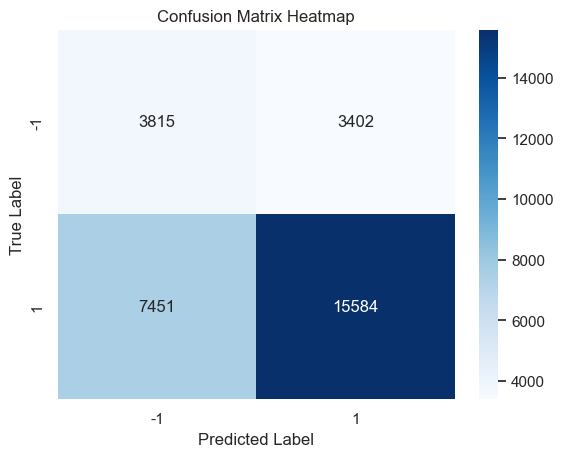

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["-1", "1"], yticklabels=["-1", "1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


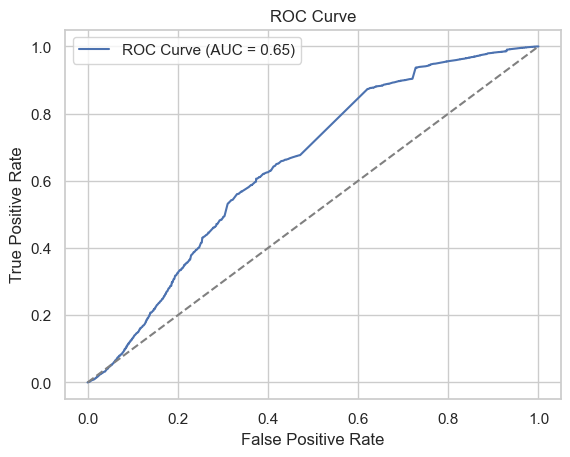

In [58]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(true_labels, sentiment_scores, pos_label=1)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [99]:
import pandas as pd

def evaluate_predictions(G, predictions):
    """
    Evaluate prediction accuracy for edge labels.

    Parameters:
        G (nx.MultiDiGraph): The input graph.
        predictions (dict): Dictionary of predicted labels for edges.

    Returns:
        accuracy (float): Overall accuracy of predictions.
    """
    correct = 0
    total = 0

    for (u, v), predicted_label in predictions.items():
        try:
            # Access the actual label of the edge
            actual_label = G[u][v][0].get('label', 0)
            if predicted_label == actual_label:
                correct += 1
            total += 1
        except (KeyError, IndexError):
            # Handle cases where 'label' or edge data is missing
            continue

    accuracy = correct / total if total > 0 else 0.0
    return accuracy


# Step 1: Predict edge labels using each method
balance_predictions = predict_existing_edge_labels(G)  # Assuming you have this function
status_predictions = predict_status(G)  # Assuming Status Theory prediction function exists

# Use sentiment polarity for edge prediction
sentiment_predictions = {
    (u, v): 1 if edge_data.get('sentiment', 0) > 0 else -1
    for u, v, edge_data in G.edges(data=True)
}

# Step 2: Evaluate predictions
balance_accuracy = evaluate_predictions(G, balance_predictions)
status_accuracy = evaluate_predictions(G, status_predictions)
sentiment_accuracy = evaluate_predictions(G, sentiment_predictions)

# Step 3: Create a comparison table
results = pd.DataFrame({
    "Method": ["Balance Theory", "Status Theory", "Sentiment Analysis"],
    "Accuracy": [balance_accuracy, status_accuracy, sentiment_accuracy]
})

# Display the results
print(results)


               Method  Accuracy
0      Balance Theory  0.871612
1       Status Theory  0.323041
2  Sentiment Analysis  0.236338


# Redoing some stuff to confirm:

## TRIADS

In [ ]:
As a Undirected Network

In [154]:
import networkx as nx

def compute_dataset_statistics(G):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    positive_edges = sum(1 for _, _, d in G.edges(data=True) if d.get('label') == 1)
    negative_edges = sum(1 for _, _, d in G.edges(data=True) if d.get('label') == -1)

    pos_ratio = positive_edges / num_edges * 100
    neg_ratio = negative_edges / num_edges * 100

    return {
        "Nodes": num_nodes,
        "Edges": num_edges,
        "+ edges (%)": round(pos_ratio, 2),
        "- edges (%)": round(neg_ratio, 2),
    }

wiki_stats = compute_dataset_statistics(G)
print(wiki_stats)


{'Nodes': 2934, 'Edges': 30252, '+ edges (%)': 76.14, '- edges (%)': 23.86}


In [155]:
from itertools import combinations

def calculate_triad_stats(G):
    triad_types = {"T3": 0, "T1": 0, "T2": 0, "T0": 0}
    total_triads = 0

    for u in G.nodes():
        neighbors = list(G.neighbors(u))
        for v, w in combinations(neighbors, 2):
            edges = [
                G[u][v][0].get('label', 0) if G.has_edge(u, v) else 0,
                G[v][w][0].get('label', 0) if G.has_edge(v, w) else 0,
                G[u][w][0].get('label', 0) if G.has_edge(u, w) else 0,
            ]
            pos_count = edges.count(1)
            neg_count = edges.count(-1)

            # Only increment total_triads when a valid triad type is classified
            if pos_count == 3:
                triad_types["T3"] += 1
                total_triads += 1
            elif pos_count == 1 and neg_count == 2:
                triad_types["T1"] += 1
                total_triads += 1
            elif pos_count == 2 and neg_count == 1:
                triad_types["T2"] += 1
                total_triads += 1
            elif neg_count == 3:
                triad_types["T0"] += 1
                total_triads += 1

    # Compute fractions only if total_triads is greater than 0 to avoid division by zero
    triad_fractions = {key: value / total_triads if total_triads > 0 else 0 for key, value in triad_types.items()}
    return triad_types, triad_fractions, total_triads

# Example usage
triad_counts, triad_fractions, total_triads = calculate_triad_stats(G)
print("Triad Counts:", triad_counts)
print("Triad Fractions:", triad_fractions)
print("Total Triads:", total_triads)


Triad Counts: {'T3': 63106, 'T1': 11006, 'T2': 21483, 'T0': 1610}
Triad Fractions: {'T3': 0.6492052877938378, 'T1': 0.11322462836273854, 'T2': 0.2210071498379713, 'T0': 0.016562934005452393}
Total Triads: 97205


In [162]:
import random
import networkx as nx
from itertools import combinations
import copy

def compute_expected_fractions(G, num_shuffles=50):
    triad_type_sums = {"T3": 0, "T1": 0, "T2": 0, "T0": 0}
    original_labels = [G[u][v][k]['label'] for u, v, k in G.edges(keys=True)]
    
    for _ in range(num_shuffles):
        # Create a deep copy of the graph to shuffle on
        G_copy = copy.deepcopy(G)
        
        # Shuffle labels and assign them to the copied graph
        shuffled_labels = random.sample(original_labels, len(original_labels))
        for i, (u, v, k) in enumerate(G_copy.edges(keys=True)):
            G_copy[u][v][k]['label'] = shuffled_labels[i]
        
        # Calculate triad fractions on the copied graph
        _, triad_fractions, _ = calculate_triad_stats(G_copy)
        for key in triad_type_sums:
            triad_type_sums[key] += triad_fractions[key]
    
    # Compute expected fractions
    expected_fractions = {key: value / num_shuffles for key, value in triad_type_sums.items()}
    return expected_fractions

# Example usage:
# Assuming G is your directed MultiDiGraph with 'label' attributes on edges
expected_fractions = compute_expected_fractions(G, num_shuffles=30)
print("Expected Fractions:", expected_fractions)


Expected Fractions: {'T3': 0.4414550006001063, 'T1': 0.1301280798312844, 'T2': 0.41469540318570725, 'T0': 0.013721516382902114}


In [163]:
def compute_surprise_values(triad_counts, expected_fractions, total_triads):
    surprises = {}
    for triad, count in triad_counts.items():
        p0_ti = expected_fractions[triad]
        expected_ti = p0_ti * total_triads
        std_dev = np.sqrt(total_triads * p0_ti * (1 - p0_ti))
        surprises[triad] = (count - expected_ti) / std_dev if std_dev > 0 else 0
    return surprises

surprises = compute_surprise_values(triad_counts, expected_fractions, total_triads)
print("Surprise Values:", surprises)


Surprise Values: {'T3': 130.4408531962737, 'T1': -15.664138942862909, 'T2': -122.5722072772025, 'T0': 7.615151332761188}


In [164]:
import pandas as pd

table_data = {
    "Triad": ["T3", "T1", "T2", "T0"],
    "|Ti|": [triad_counts["T3"], triad_counts["T1"], triad_counts["T2"], triad_counts["T0"]],
    "p(Ti)": [triad_fractions["T3"], triad_fractions["T1"], triad_fractions["T2"], triad_fractions["T0"]],
    "p0(Ti)": [expected_fractions["T3"], expected_fractions["T1"], expected_fractions["T2"], expected_fractions["T0"]],
    "s(Ti)": [surprises["T3"], surprises["T1"], surprises["T2"], surprises["T0"]],
}

df = pd.DataFrame(table_data)

df

,Triad,|Ti|,p(Ti),p0(Ti),s(Ti)
0,T3,63106,0.649205,0.441455,130.440853
1,T1,11006,0.113225,0.130128,-15.664139
2,T2,21483,0.221007,0.414695,-122.572207
3,T0,1610,0.016563,0.013722,7.615151


In [ ]:
print(df.to_latex(index=False, float_format="%.4f"))

In [16]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from networkx.algorithms.community import modularity, partition_quality
from collections import Counter

def spectral_clustering_from_df(df, num_communities=4, num_iterations=20):
    """
    Perform spectral clustering on the graph derived from the DataFrame df to detect communities.
    This will run multiple iterations and return the best partition based on modularity.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing 'SRC' and 'TGT' columns representing interactions.
        num_communities (int): The number of communities to detect.
        num_iterations (int): The number of iterations to run and select the best partition.

    Returns:
        best_partition (dict): A dictionary where keys are node IDs and values are community IDs.
        best_modularity (float): Modularity score of the detected partition.
        best_community_sizes (Counter): Sizes of the communities in the partition.
        best_coverage (float): Coverage score of the partition.
        best_performance (float): Performance score of the partition.
        best_conductance (float): Conductance score of the partition.
    """
    # Step 1: Create a graph from the DataFrame (SRC and TGT are nodes, interactions are edges)
    G = nx.Graph()
    for idx, row in df.iterrows():
        # Ensure valid edges, remove any nodes that aren't connected to anything
        if row['SRC'] != row['TGT']:  # No self-loops
            G.add_edge(row['SRC'], row['TGT'])

    # Step 2: Compute the normalized Laplacian matrix
    L = nx.normalized_laplacian_matrix(G).todense()

    # Step 3: Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    best_partition = None
    best_modularity = -float('inf')
    best_community_sizes = None
    best_coverage = -1
    best_performance = -1
    best_conductance = -1

    # Run multiple iterations
    for _ in range(num_iterations):
        # Step 4: Select the eigenvectors corresponding to the smallest eigenvalues
        # We select the first num_communities eigenvectors (excluding the first one)
        embedding = eigenvectors[:, 1:num_communities+1]  # Skip the zero eigenvalue

        # Step 5: Normalize the rows of the embedding
        normalized_embedding = normalize(embedding, axis=1)

        # Step 6: Apply K-means clustering to the normalized embedding
        kmeans = KMeans(n_clusters=num_communities, random_state=42)
        labels = kmeans.fit_predict(normalized_embedding)

        # Step 7: Create a partition dictionary
        partition = {node: labels[i] for i, node in enumerate(G.nodes())}

        # Step 8: Create the list of communities (list of sets)
        communities = {}
        for i, node in enumerate(G.nodes()):
            community_id = labels[i]
            if community_id not in communities:
                communities[community_id] = set()
            communities[community_id].add(node)

        # Step 9: Compute modularity, coverage, performance, and conductance
        modularity_score = modularity(G, list(communities.values()))

        # Ensure partition_quality is used correctly
        try:
            coverage, performance = partition_quality(G, list(communities.values()))
        except Exception as e:
            print(f"Error in calculating partition quality: {e}")
            coverage, performance = 0, 0  # Return defaults if error occurs

        # Conductance (between the first two communities if available)
        if len(communities) > 1:
            conductance_score = nx.conductance(G, communities[0], communities[1])
        else:
            conductance_score = 0

        # Step 10: If the current partition has better modularity, update the best values
        if modularity_score > best_modularity:
            best_modularity = modularity_score
            best_partition = partition
            best_community_sizes = Counter(labels)
            best_coverage = coverage
            best_performance = performance
            best_conductance = conductance_score

    # Step 11: Return results
    return best_partition, best_modularity, best_community_sizes, best_coverage, best_performance, best_conductance

# Example usage with your DataFrame:
# Assuming `df` is your DataFrame that contains the data
num_communities = 3  # Choose the number of communities to detect
num_iterations = 50   # Number of iterations to run

best_partition, best_modularity, best_community_sizes, best_coverage, best_performance, best_conductance = spectral_clustering_from_df(df, num_communities, num_iterations)

# Print results
print(f"Best Modularity: {best_modularity:.4f}")
print(f"Community sizes: {best_community_sizes}")
print(f"Coverage: {best_coverage:.4f}")
print(f"Performance: {best_performance:.4f}")
print(f"Conductance: {best_conductance:.4f}")


/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change fr

Best Modularity: 0.3084
Community sizes: Counter({0: 1051, 2: 1034, 1: 883})
Coverage: 0.6465
Performance: 0.6670
Conductance: 0.1080


/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Data Types:
SRC            object
TGT            object
VOT             int64
RES             int64
YEA             int64
DAT            object
TXT            object
cleaned_TXT    object
dtype: object

Sample Data:
          SRC  TGT  VOT  RES   YEA                  DAT  \
0   Steel1943  BDD    1    1  2013  2013-04-19 23:13:00   
1  Cuchullain  BDD    1    1  2013  2013-04-20 01:04:00   
2   INeverCry  BDD    1    1  2013  2013-04-19 23:43:00   
3   Cncmaster  BDD    1    1  2013  2013-04-20 00:11:00   
4  Miniapolis  BDD    1    1  2013  2013-04-20 00:56:00   

                                                 TXT  \
0                                  '''''' as co-nom.   
1                             '''''' as nominator.--   
2                                   '''''' per noms.   
3  '''''' per noms. BDD is a strong contributor w...   
4  '''''', with great pleasure. I work with BDD a...   

                                         cleaned_TXT  
0                                    

/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/ADC/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change fr


Best Modularity: 0.3084
Community sizes: Counter({0: 1051, 2: 1034, 1: 883})
Coverage: 0.6465
Performance: 0.6670
Conductance: 0.1080

Merged DataFrame:
              User  Year  Support (%)  Oppose (%)  Votes Promoted  Community
0         07bargem  2010     0.000000  100.000000      6       No          2
1         1234r00t  2010     0.000000  100.000000      6       No          0
2          28bytes  2010    51.724138   41.379310     58       No          2
3          28bytes  2011    98.461538    0.769231    130      Yes          2
4  5 albert square  2011    97.115385    1.923077    104      Yes          2

Aggregated Voting Behavior per Community:
   Community  Average Support (%)  Average Oppose (%)  Average Votes  \
0          0            47.223182           44.086739      71.574074   
1          1            52.419996           40.247872      82.723214   
2          2            44.280303           47.552315      57.250000   

   Proportion Promoted  
0             0.395062  
1 

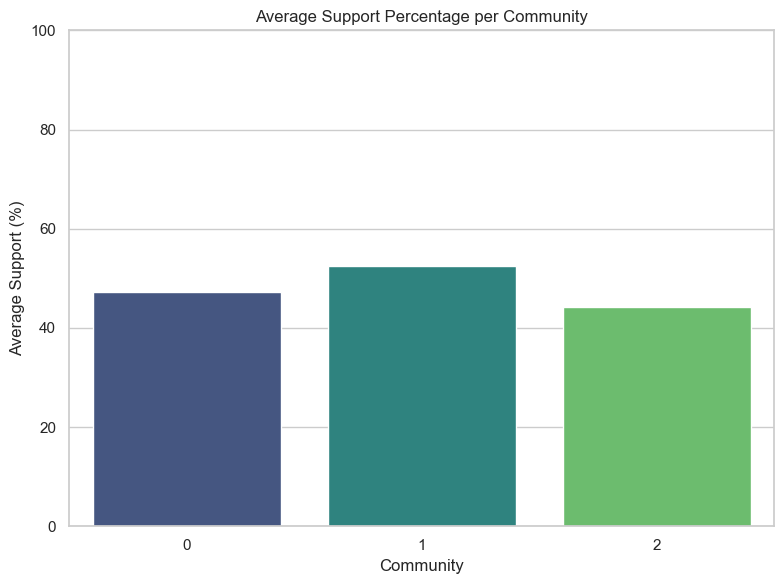

/var/folders/dd/q59hq4f165zf1s43dyw9y7d80000gn/T/ipykernel_9852/918149956.py:241: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Community', y='Proportion Promoted', data=voting_behavior, palette='magma')


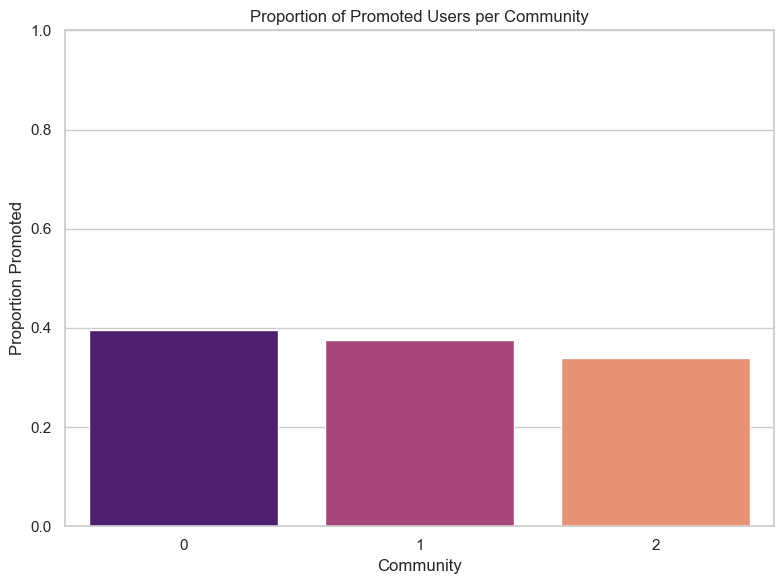

In [20]:
import os
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from networkx.algorithms.community import modularity, partition_quality
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Step 1: Ensure 'plots' Directory Exists
# -----------------------------

# Ensure 'plots' directory exists
if not os.path.exists('plots'):
    os.makedirs('plots')

# -----------------------------
# Step 2: Load and Explore the Dataset
# -----------------------------

# Load the processed dataset
df = pd.read_csv("./Data/wiki_RfA_2010_2013.csv")
print("Data Types:")
print(df.dtypes)

# Display the first few rows of the DataFrame
print("\nSample Data:")
print(df.head())

# -----------------------------
# Step 3: Preprocess Data to Create voting_df
# -----------------------------

# Preprocess data to create voting_df
# Group by 'TGT' and 'YEA' to aggregate voting behavior
voting_df = df.groupby(['TGT', 'YEA']).agg(
    Support_Percentage=('VOT', lambda x: (x == 1).mean() * 100),
    Oppose_Percentage=('VOT', lambda x: (x == -1).mean() * 100),
    Total_Votes=('VOT', 'count'),
    Promoted=('RES', lambda x: 'Yes' if x.iloc[0] == 1 else 'No')
).reset_index()

# Rename columns for clarity
voting_df.rename(columns={
    'TGT': 'User',
    'YEA': 'Year',
    'Support_Percentage': 'Support (%)',
    'Oppose_Percentage': 'Oppose (%)',
    'Total_Votes': 'Votes',
    'Promoted': 'Promoted'
}, inplace=True)

# Display the first few rows of voting_df
print("\nVoting Behavior DataFrame:")
print(voting_df.head())

# -----------------------------
# Step 4: Define Spectral Clustering Function
# -----------------------------

def spectral_clustering_from_df(df, num_communities=4, num_iterations=20):
    """
    Perform spectral clustering on the graph derived from the DataFrame df to detect communities.
    This will run multiple iterations and return the best partition based on modularity.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing 'SRC' and 'TGT' columns representing interactions.
        num_communities (int): The number of communities to detect.
        num_iterations (int): The number of iterations to run and select the best partition.

    Returns:
        best_partition (dict): A dictionary where keys are node IDs and values are community IDs.
        best_modularity (float): Modularity score of the detected partition.
        best_community_sizes (Counter): Sizes of the communities in the partition.
        best_coverage (float): Coverage score of the partition.
        best_performance (float): Performance score of the partition.
        best_conductance (float): Conductance score of the partition.
    """
    # Step 1: Create a graph from the DataFrame (SRC and TGT are nodes, interactions are edges)
    G = nx.Graph()
    for idx, row in df.iterrows():
        # Ensure valid edges, remove any nodes that aren't connected to anything
        if row['SRC'] != row['TGT']:  # No self-loops
            G.add_edge(row['SRC'], row['TGT'])

    # Step 2: Compute the normalized Laplacian matrix
    L = nx.normalized_laplacian_matrix(G).todense()

    # Step 3: Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    best_partition = None
    best_modularity = -float('inf')
    best_community_sizes = None
    best_coverage = -1
    best_performance = -1
    best_conductance = -1

    # Run multiple iterations
    for _ in range(num_iterations):
        # Step 4: Select the eigenvectors corresponding to the smallest eigenvalues
        # We select the first num_communities eigenvectors (excluding the first one)
        embedding = eigenvectors[:, 1:num_communities+1]  # Skip the zero eigenvalue

        # Step 5: Normalize the rows of the embedding
        normalized_embedding = normalize(embedding, axis=1)

        # Step 6: Apply K-means clustering to the normalized embedding
        kmeans = KMeans(n_clusters=num_communities, random_state=42)
        labels = kmeans.fit_predict(normalized_embedding)

        # Step 7: Create a partition dictionary
        partition = {node: labels[i] for i, node in enumerate(G.nodes())}

        # Step 8: Create the list of communities (list of sets)
        communities = {}
        for i, node in enumerate(G.nodes()):
            community_id = labels[i]
            if community_id not in communities:
                communities[community_id] = set()
            communities[community_id].add(node)

        # Step 9: Compute modularity, coverage, performance, and conductance
        modularity_score = modularity(G, list(communities.values()))

        # Ensure partition_quality is used correctly
        try:
            coverage, performance = partition_quality(G, list(communities.values()))
        except Exception as e:
            print(f"Error in calculating partition quality: {e}")
            coverage, performance = 0, 0  # Return defaults if error occurs

        # Conductance (between the first two communities if available)
        if len(communities) > 1:
            # Compute conductance between each pair and take the minimum
            conductance_scores = []
            community_ids = list(communities.keys())
            for i in range(len(community_ids)):
                for j in range(i + 1, len(community_ids)):
                    conductance = nx.conductance(G, communities[community_ids[i]], communities[community_ids[j]])
                    conductance_scores.append(conductance)
            conductance_score = min(conductance_scores) if conductance_scores else 0
        else:
            conductance_score = 0

        # Step 10: If the current partition has better modularity, update the best values
        if modularity_score > best_modularity:
            best_modularity = modularity_score
            best_partition = partition
            best_community_sizes = Counter(labels)
            best_coverage = coverage
            best_performance = performance
            best_conductance = conductance_score

    # Step 11: Return results
    return best_partition, best_modularity, best_community_sizes, best_coverage, best_performance, best_conductance

# -----------------------------
# Step 5: Perform Community Detection
# -----------------------------

# Define parameters
num_communities = 3  # Choose the number of communities to detect
num_iterations = 50   # Number of iterations to run

# Perform spectral clustering
best_partition, best_modularity, best_community_sizes, best_coverage, best_performance, best_conductance = spectral_clustering_from_df(df, num_communities, num_iterations)

# Print results
print(f"\nBest Modularity: {best_modularity:.4f}")
print(f"Community sizes: {best_community_sizes}")
print(f"Coverage: {best_coverage:.4f}")
print(f"Performance: {best_performance:.4f}")
print(f"Conductance: {best_conductance:.4f}")

# -----------------------------
# Step 6: Merge Community Partitions with Voting Data
# -----------------------------

# Convert the partition dictionary to a DataFrame
partition_df = pd.DataFrame(list(best_partition.items()), columns=['User', 'Community'])

# Merge the community assignments with the voting data
merged_df = pd.merge(voting_df, partition_df, on='User', how='left')

# Check for any users without a community assignment
missing_communities = merged_df['Community'].isnull().sum()
if missing_communities > 0:
    print(f"\nWarning: {missing_communities} users do not have a community assignment.")

# Display the merged DataFrame
print("\nMerged DataFrame:")
print(merged_df.head())

# -----------------------------
# Step 7: Analyze Voting Behavior Within Communities
# -----------------------------

# Group by Community and compute aggregated statistics
voting_behavior = merged_df.groupby('Community').agg({
    'Support (%)': 'mean',
    'Oppose (%)': 'mean',
    'Votes': 'mean',
    'Promoted': lambda x: (x == 'Yes').mean()  # Proportion of promoted users
}).reset_index()

# Rename columns for clarity
voting_behavior.rename(columns={
    'Support (%)': 'Average Support (%)',
    'Oppose (%)': 'Average Oppose (%)',
    'Votes': 'Average Votes',
    'Promoted': 'Proportion Promoted'
}, inplace=True)

print("\nAggregated Voting Behavior per Community:")
print(voting_behavior)

# -----------------------------
# Step 8: Visualize the Results
# -----------------------------

# Set plot style
sns.set(style="whitegrid")

# Plot Average Support (%) per Community
plt.figure(figsize=(8,6))
sns.barplot(x='Community', y='Average Support (%)', data=voting_behavior, palette='viridis')
plt.title('Average Support Percentage per Community')
plt.xlabel('Community')
plt.ylabel('Average Support (%)')
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('plots/average_support_per_community.png')
plt.show()

# Plot Proportion Promoted per Community
plt.figure(figsize=(8,6))
sns.barplot(x='Community', y='Proportion Promoted', data=voting_behavior, palette='magma')
plt.title('Proportion of Promoted Users per Community')
plt.xlabel('Community')
plt.ylabel('Proportion Promoted')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('plots/proportion_promoted_per_community.png')
plt.show()



Missing community assignments for SRC: 0
Missing community assignments for TGT: 0

Inter-Community Voting Behavior:
   SRC_Community  TGT_Community  Total_Votes  Support_Percentage  \
0              0              0         8078           70.760089   
1              0              1         1093           69.990851   
2              0              2         3172           70.933165   
3              1              0          809           76.637824   
4              1              1         6106           73.075663   
5              1              2         1556           74.807198   
6              2              0         2708           71.491876   
7              2              1         2066           65.295257   
8              2              2         6722           71.005653   

   Oppose_Percentage  
0          22.468433  
1          23.787740  
2          23.076923  
3          19.530284  
4          21.110383  
5          20.179949  
6          21.676514  
7          26.7666

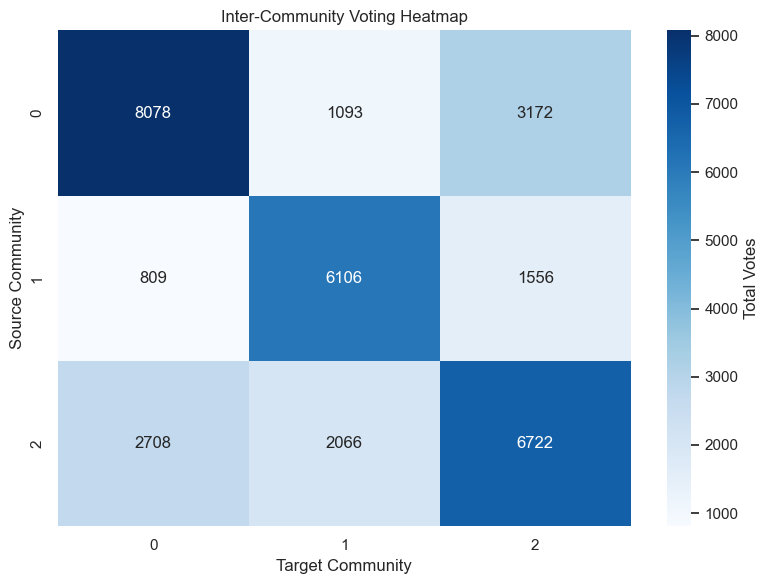

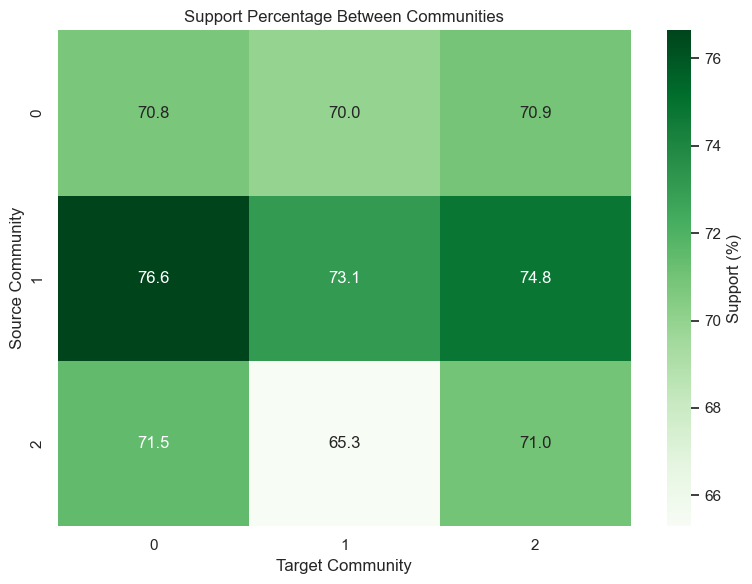

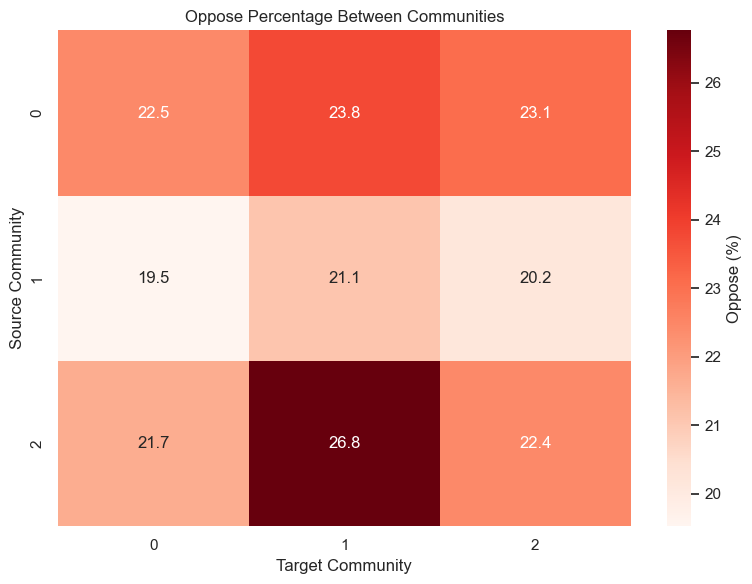

In [21]:
# -----------------------------
# Step 9: Analyze Inter-Community Voting
# -----------------------------

# Add community assignments to the original DataFrame for both SRC and TGT
df_with_communities = df.copy()
df_with_communities = df_with_communities.merge(partition_df.rename(columns={'User': 'SRC', 'Community': 'SRC_Community'}),
                                                on='SRC', how='left')
df_with_communities = df_with_communities.merge(partition_df.rename(columns={'User': 'TGT', 'Community': 'TGT_Community'}),
                                                on='TGT', how='left')

# Check for missing community assignments
missing_src_communities = df_with_communities['SRC_Community'].isnull().sum()
missing_tgt_communities = df_with_communities['TGT_Community'].isnull().sum()

print(f"\nMissing community assignments for SRC: {missing_src_communities}")
print(f"Missing community assignments for TGT: {missing_tgt_communities}")

# Filter out rows where either SRC or TGT does not have a community assignment
df_with_communities = df_with_communities.dropna(subset=['SRC_Community', 'TGT_Community'])

# Group by source and target communities to calculate voting behavior between communities
inter_community_votes = df_with_communities.groupby(['SRC_Community', 'TGT_Community']).agg(
    Total_Votes=('VOT', 'count'),
    Support_Percentage=('VOT', lambda x: (x == 1).mean() * 100),
    Oppose_Percentage=('VOT', lambda x: (x == -1).mean() * 100),
).reset_index()

# Display inter-community voting behavior
print("\nInter-Community Voting Behavior:")
print(inter_community_votes)

# -----------------------------
# Step 10: Visualize Inter-Community Voting Behavior
# -----------------------------

# Pivot the data to create a matrix for visualization
inter_community_matrix = inter_community_votes.pivot(index='SRC_Community', columns='TGT_Community', values='Total_Votes').fillna(0)

# Plot a heatmap of inter-community voting
plt.figure(figsize=(8, 6))
sns.heatmap(inter_community_matrix, annot=True, fmt=".0f", cmap='Blues', cbar_kws={'label': 'Total Votes'})
plt.title('Inter-Community Voting Heatmap')
plt.xlabel('Target Community')
plt.ylabel('Source Community')
plt.tight_layout()
plt.savefig('plots/inter_community_voting_heatmap.png')
plt.show()

# Plot Support Percentage between communities
support_matrix = inter_community_votes.pivot(index='SRC_Community', columns='TGT_Community', values='Support_Percentage').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(support_matrix, annot=True, fmt=".1f", cmap='Greens', cbar_kws={'label': 'Support (%)'})
plt.title('Support Percentage Between Communities')
plt.xlabel('Target Community')
plt.ylabel('Source Community')
plt.tight_layout()
plt.savefig('plots/inter_community_support_heatmap.png')
plt.show()

# Plot Oppose Percentage between communities
oppose_matrix = inter_community_votes.pivot(index='SRC_Community', columns='TGT_Community', values='Oppose_Percentage').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(oppose_matrix, annot=True, fmt=".1f", cmap='Reds', cbar_kws={'label': 'Oppose (%)'})
plt.title('Oppose Percentage Between Communities')
plt.xlabel('Target Community')
plt.ylabel('Source Community')
plt.tight_layout()
plt.savefig('plots/inter_community_oppose_heatmap.png')
plt.show()
